In [1]:
#!/usr/bin/env python3
import numpy as np
from scipy.stats import spearmanr
import sys
import pylab as pl
import os
import glob
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from scipy import signal
from collections import Counter
from brainiak import utils
import brainiak.utils.fmrisim
import brainiak.utils.utils
from brainiak.utils import utils
from brainiak.isc import isc, isfc, permutation_isc
import math
import deepdish as dd
from scipy.ndimage.filters import uniform_filter1d
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats.mstats import gmean

#sys.path.append("/home/my_libraries/")

np.set_printoptions(precision=4)


#import hrf_conv
%matplotlib inline

path = '/home/msachs/music_emo_events'
datapath = os.path.join(path,'emo_event_ratings')
files = [elem for elem in os.listdir(datapath) if '.txt' in elem]
removes = ['5fbafbe5d40ee2bc4602c003', '5e596c7962d4f9027fc4b594', '60062e10a1789198743db1cb', '6009030f66ec425c7a1eaef0', '5fef6fc8b890b1dd5a155e6a']
#these removes come from an error in the first part 
#filesrm = [elem for elem in files if any(removes in elem)]
#any(substring in files for substring in removes)

#attn_rmv = ['5fc5e705e619131660e4a3f9','5fb4bc284a5cf70e56d9ad1c','5e68175076ef78000c8f91a3','5e29e18672e2fa0420f79dec','5fd934baf0fc1a3fc033e873']
#first three for attention, last for missing data 
nsubs = len(files)- len(removes)

spart_lens = np.array([323.9444898 , 256.44408163, 315.68979592, 323.31755102,
       257.01877551, 315.71591837, 307.85306122, 282.30530612,
       305.89387755, 307.27836735, 288.15673469, 305.21469388])
spart_lens_attn = np.array([323.988, 256.51066667, 329.748,
       323.39066667, 257.044, 327.97733333,
       307.88133333, 282.324, 318.996,
       307.32666667, 288.19066667, 318.18533333])

#cuts = [324,580,323,580,307,590,307,574.3]
cuts = [0,323.970,580.440,0,323.317,580.361,0,307.853,590.184,0,307.278,590.209]

fulldur = 896
studynames = ['musevents_a1_1','musevents_a1_2','musevents_a1_3','musevents_a2_1','musevents_a2_2','musevents_a2_3',\
              'musevents_b1_1','musevents_b1_2','musevents_b1_3','musevents_b2_1','musevents_b2_2','musevents_b2_3']
pieces = ['a1','a2','b1','b2']
mareika = [314,305]
clipcount = 16

#get survey with study id
survey = pd.read_csv(os.path.join(path,'music_events_postsurvey_clean.csv'))
survey = survey.iloc[np.where(survey.issues != 1)[0]] #removing anyone that had multiple buffering issues (02-04)
survey = survey[survey.subjectid.str.startswith(('5','6'))] #removing anyone without a 5
sublist = np.array(survey.subjectid)
print('Found num subjects:', len(files)/3, 'clean sublist is:',len(sublist),'unique subjects is:',len(np.unique(sublist)))

#load the transition time points 
apiece = pd.read_csv(os.path.join(path,'music_event_transitions_final_pieceA.csv'))
bpiece = pd.read_csv(os.path.join(path,'music_event_transitions_final_pieceB.csv'))
emos = ['calm','happy','sad','anxious','nostalgic']

apiece.emo[apiece.emo.str.contains('Joy')] = 'happy' 
bpiece.emo[bpiece.emo.str.contains('Joy')] = 'happy' 
apiece.rename(columns={'studynbme':'studyname'},inplace = True)
bpiece.rename(columns={'studynbme':'studyname'},inplace = True)
for e in emos:
    apiece.emo[apiece.emo.str.contains(e.capitalize())] = e 
    bpiece.emo[bpiece.emo.str.contains(e.capitalize())] = e 
transitions_a1 = apiece.onset[np.where(apiece.onset != 0)[0]][0:15].values - apiece.offset[0:15].values
transitions_a2 = apiece.onset[np.where(apiece.onset != 0)[0]][15:31].values - apiece.offset[16:31].values
transitions_b1 = bpiece.onset[np.where(bpiece.onset != 0)[0]][0:15].values - bpiece.offset[0:15].values
transitions_b2 = bpiece.onset[np.where(bpiece.onset != 0)[0]][15:31].values - bpiece.offset[16:31].values
fulltrans = pd.concat([apiece,bpiece])
fulltrans = fulltrans.reset_index()
emos_in_clips = [6,5,5]*4
print(apiece.head())

Found num subjects: 199.0 clean sublist is: 182 unique subjects is: 182


/home/msachs/.conda/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/msachs/.conda/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/msachs/.conda/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/msachs/.conda/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:82: SettingWithCopyWarning

   version  order        emo  num       nickname  onset  offset  \
0        1      1  nostalgic    1     DorianWalk      0      60   
1        1      2       calm    1   CloudWalking     69     123   
2        1      3      happy    1   FrogCatching    132     183   
3        1      4        sad    1         Tether    192     240   
4        1      5    anxious    1  IncomingTrain    249     297   

        studyname condition  con2 con3  
0  musevents_a1_1       NaN   NaN  NaN  
1  musevents_a1_1       NaN   0.0    N  
2  musevents_a1_1        PP   0.0    C  
3  musevents_a1_1        PN   0.0    J  
4  musevents_a1_1        NN   NaN    S  


In [2]:
outdic = {}
files.sort()

goodscount = -1
studycount = np.zeros((4,len(sublist)))
remove_list = []
for i,s in enumerate(sublist):
    subfiles = [elem for elem in files if s in elem]
    subfiles.sort()
    study = survey.studyid.iloc[np.where(survey.subjectid == s)[0]]
        
    if len(subfiles) != 3:
        print(i,s,'did not complete the song, moving on...')
        remove_list.append(s)
        continue
    if any(rmv in s for rmv in removes):
        print(i,s,'did not complete the song, moving on...')
        remove_list.append(s)
        continue
        
    for fcount,file in enumerate(subfiles):
        studyname = file.split(sep = '-')[0]
        idx = studynames.index(studyname)
        songlen = spart_lens[idx]
        subname =  file.split(sep = '-')[1]
        subfilepath = os.path.join(datapath,file)
        
        try: 
            outdic[studyname]
            #print(fcount,file,len(outdic[studyname].keys()))
        except:
            outdic[studyname] = {}
        
        outdic[studyname][s] = {}
    

        fulldata = []
        with open(subfilepath) as f:
            for line in f:
                line = line.partition('##')[0]
                line = line.rstrip()
                if 'On' in line or 'Off' in line:
                    data = line.split()
                    if len(fulldata) > 0:
                        fulldata = np.vstack((fulldata, data))
                    else:
                        fulldata = data
        #print(data)
        if len(fulldata) > 3:
            df = pd.DataFrame(fulldata) #this is subject concatonated for all on and off all emotions and time
            #df = df.rename(columns={'0':'time','1':'emo','2':'onset'})
            df[0] = df[0].astype(float)
        else:
            print(subname,studyname,'No press or one press')
            remove_list.append(subname)
            break
        
        if '3' in studyname:
            #print(df.iloc[df.shape[0]-1][0],songlen)
            if df[df[0].between(songlen-1.5,songlen+5.7)].empty: #IF DIDN"T PRESS BETWEEN 1.5s before and 6 seconds after the change
                print(subname,studyname,'MISSED THE ATTENTION CHECK',studyname,songlen,df.iloc[df.shape[0]-1][0],df.iloc[df.shape[0]-1][1],df.iloc[df.shape[0]-1][2])
                remove_list.append(subname)
                break
            else:
                goodscount += 1
                studycount[math.floor(idx/3),i] = 1
                #print(subname,studyname,songlen,df[0][df[0].between(songlen-1.5,songlen+6)].values[0],df[1][df[0].between(songlen-1.5,songlen+6)].values[0],\
                     #df[2][df[0].between(songlen-1.5,songlen+6)].values[0])
        if s not in remove_list:
            outdic[studyname][s] = df
        else:
            del outdic[studyname][s]
            #outdic[studyname].pop(s)
            
    
#save out in a single dictionary
#if s not in remove_list:
    #dd.io.save(soutname,outdic)
        
                    
print('Number to remove:', len(remove_list),goodscount)  
for t in range(studycount.shape[0]):
    print(studynames[math.floor(t*3)], 'Goodsubs:',studycount[t,:].sum(),'n in dictionary:',len(outdic[studyname].keys()))

5fcac62f81b544773a597764 musevents_a2_3 MISSED THE ATTENTION CHECK musevents_a2_3 315.71591837 298.998768 calm Off
5f4e3cb2ab878aa1985bf0c1 musevents_b2_3 MISSED THE ATTENTION CHECK musevents_b2_3 305.21469388 265.788158 calm Off
6 5e596c7962d4f9027fc4b594 did not complete the song, moving on...
5d4100b7c983e80001746d50 musevents_b1_3 MISSED THE ATTENTION CHECK musevents_b1_3 305.89387755 274.996291 sad Off
5c55fec09fcbc40001dc50b5 musevents_a1_1 No press or one press
5e2bf2153a9311222d4892c6 musevents_a1_3 MISSED THE ATTENTION CHECK musevents_a1_3 315.68979592 305.479356 happy On
5fd8025bcfda8b1165a0b16e musevents_a1_3 MISSED THE ATTENTION CHECK musevents_a1_3 315.68979592 326.535229 happy On
5e89ad187ad752640e558c8a musevents_b1_2 No press or one press
5d62935aacd67c0015b06e8d musevents_b1_3 MISSED THE ATTENTION CHECK musevents_b1_3 305.89387755 313.142385507 nostalgic Off
5ddaa1e583e309a04100bd57 musevents_a2_3 MISSED THE ATTENTION CHECK musevents_a2_3 315.71591837 325.443473 calm O

## Get allsub_events (one or zero if on off) and plot transitions

0 musevents_a1_1 323 0 43 36 [0, 69, 132, 192, 249, 306] [60, 123, 183, 240, 297] [0, 69, 132, 192, 249, 306] [60, 123, 183, 240, 297]


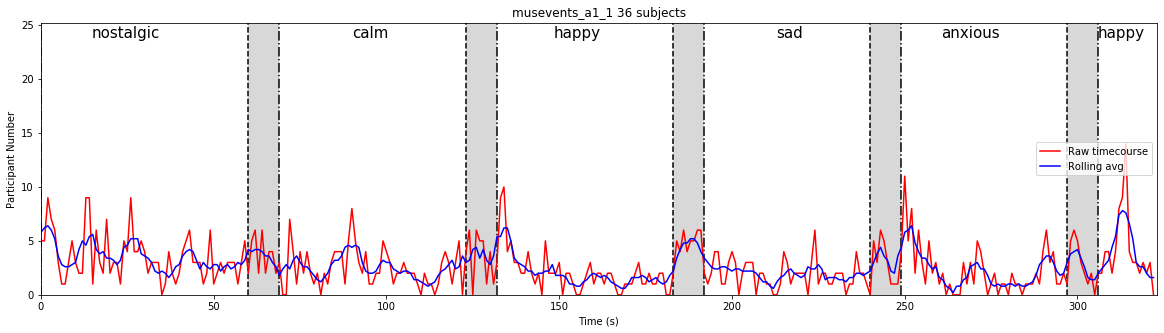

1 musevents_a1_2 256 323 42 36 [366, 417, 483, 525, 570] [360, 408, 474, 522, 561] [42, 93, 159, 201, 246] [36, 84, 150, 198, 237]
0 42 25.5 67.5
1 93 33.0 126.0
2 159 21.0 180.0
3 201 22.5 223.5
4 246 10.0 256.0


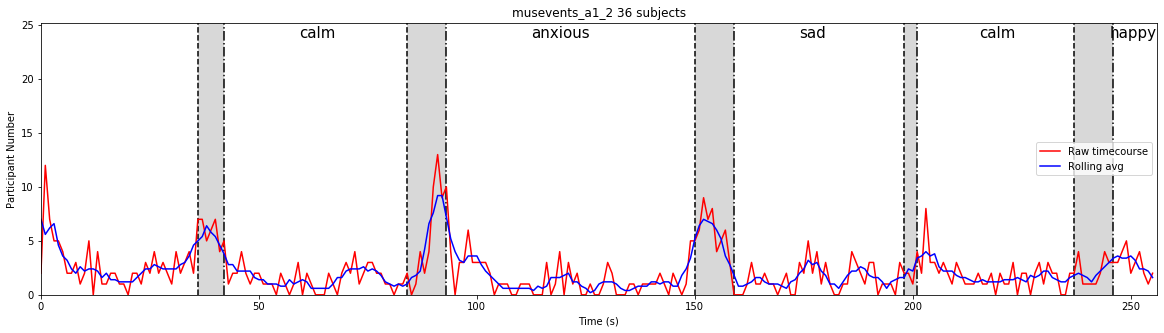

2 musevents_a1_3 315 579 42 36 [627, 684, 729, 774, 834] [618, 675, 723, 768, 825, 894] [47, 104, 149, 194, 254] [38, 95, 143, 188, 245, 314]
0 47 28.5 75.5
1 104 22.5 126.5
2 149 22.5 171.5
3 194 30.0 224.0
4 254 35.5 289.5


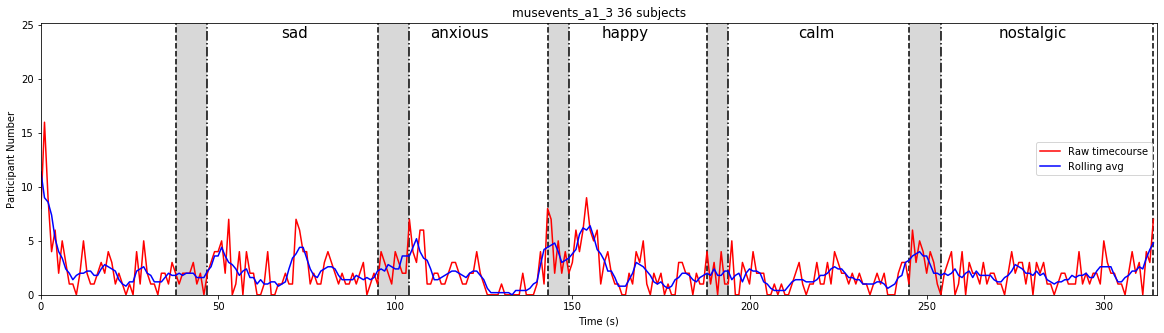

3 musevents_a2_1 323 0 47 36 [0, 69, 129, 192, 234, 300] [60, 120, 181, 231, 291] [0, 69, 129, 192, 234, 300] [60, 120, 181, 231, 291]


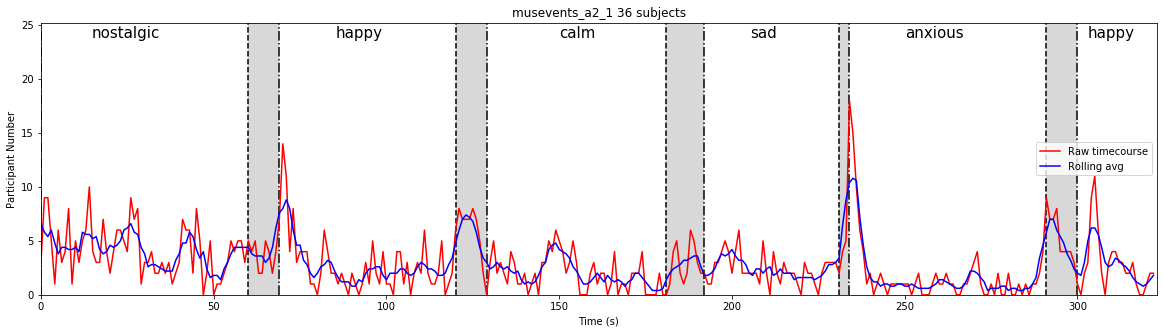

4 musevents_a2_2 257 323 47 36 [357, 402, 447, 504, 555] [348, 393, 441, 496, 546] [34, 79, 124, 181, 232] [25, 70, 118, 173, 223]
0 34 22.5 56.5
1 79 22.5 101.5
2 124 28.5 152.5
3 181 25.5 206.5
4 232 17.5 249.5


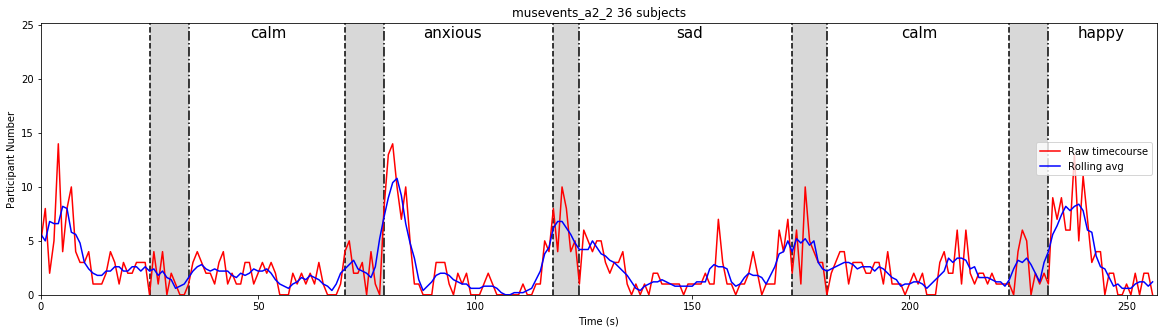

5 musevents_a2_3 315 580 47 36 [615, 672, 729, 789, 834] [609, 663, 720, 780, 828, 894] [35, 92, 149, 209, 254] [29, 83, 140, 200, 248, 314]
0 35 28.5 63.5
1 92 28.5 120.5
2 149 30.0 179.0
3 209 22.5 231.5
4 254 35.5 289.5


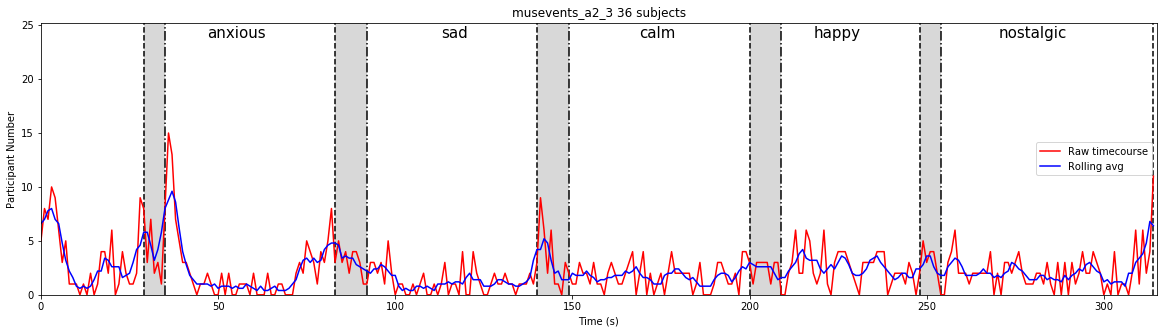

6 musevents_b1_1 307 0 41 35 [0, 45, 102, 159, 219, 279] [36, 93, 150, 210, 267] [0, 45, 102, 159, 219, 279] [36, 93, 150, 210, 267]


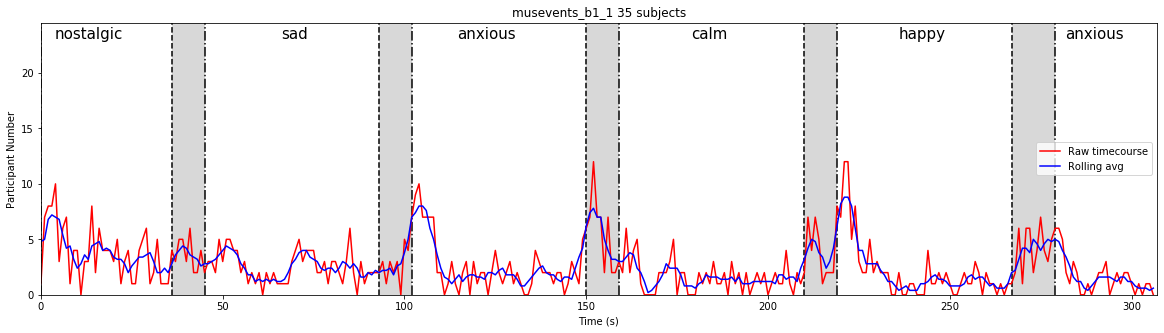

7 musevents_b1_2 282 307 41 35 [336, 399, 435, 510, 567] [327, 390, 426, 501, 558] [28, 91, 127, 202, 259] [19, 82, 118, 193, 250]
0 28 31.5 59.5
1 91 18.0 109.0
2 127 37.5 164.5
3 202 28.5 230.5
4 259 16.5 275.5


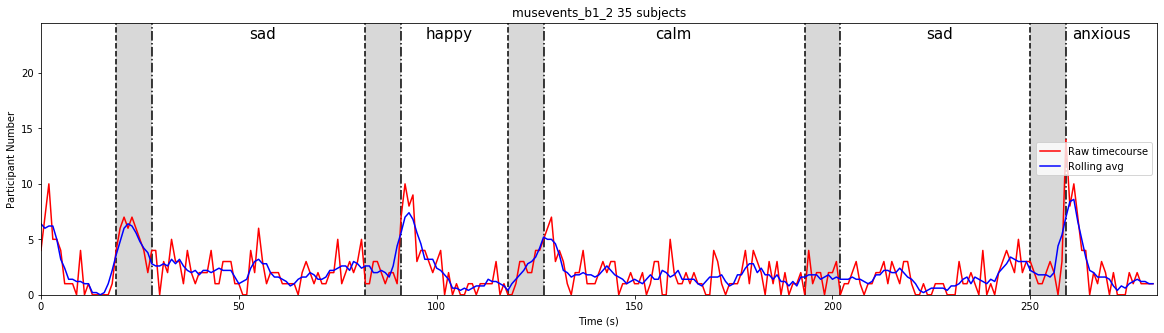

8 musevents_b1_3 305 589 40 35 [624, 678, 735, 771, 852] [615, 672, 726, 765, 843, 894] [34, 88, 145, 181, 262] [25, 82, 136, 175, 253, 304]
0 34 27.0 61.0
1 88 28.5 116.5
2 145 18.0 163.0
3 181 40.5 221.5
4 262 26.5 288.5


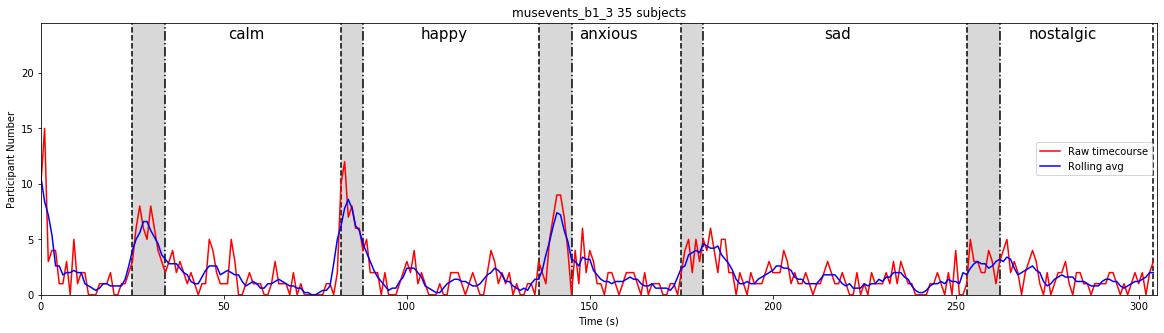

9 musevents_b2_1 307 0 50 35 [0, 45, 102, 159, 219, 279] [36, 93, 150, 210, 270] [0, 45, 102, 159, 219, 279] [36, 93, 150, 210, 270]


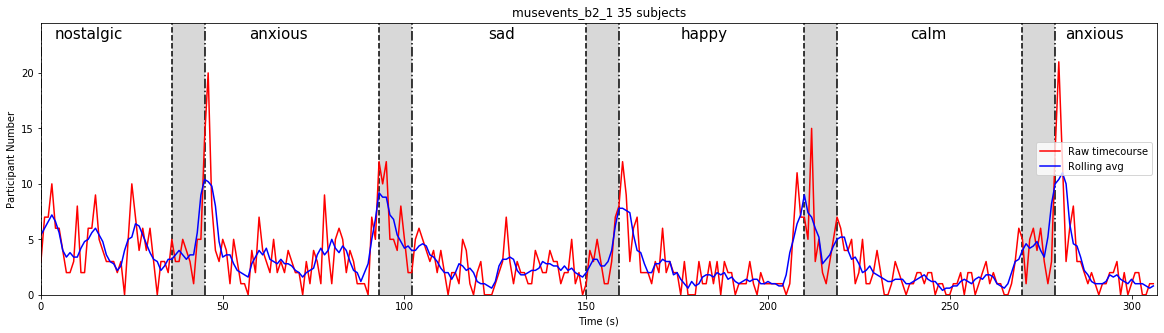

10 musevents_b2_2 288 307 50 35 [336, 393, 468, 504, 567] [327, 384, 459, 495, 558] [29, 86, 161, 197, 260] [20, 77, 152, 188, 251]
0 29 28.5 57.5
1 86 37.5 123.5
2 161 18.0 179.0
3 197 31.5 228.5
4 260 19.0 279.0


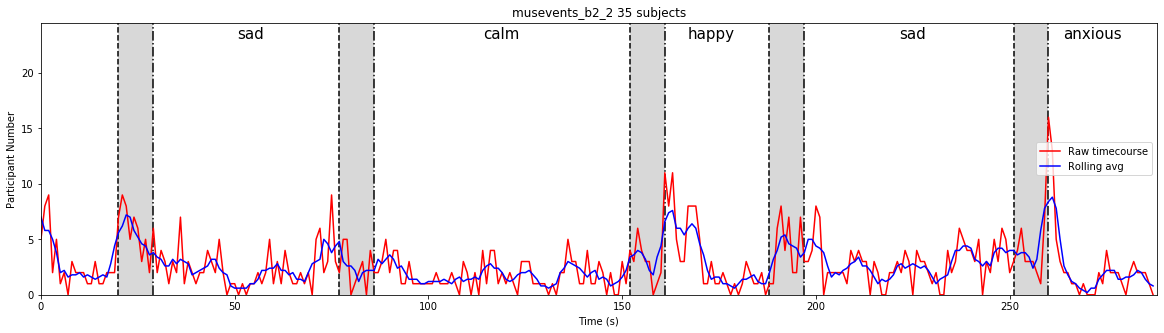

11 musevents_b2_3 305 595 50 35 [627, 684, 735, 816, 852] [615, 675, 727, 807, 849, 894] [37, 94, 145, 226, 262] [25, 85, 137, 217, 259, 304]
0 37 28.5 65.5
1 94 25.5 119.5
2 145 40.5 185.5
3 226 18.0 244.0
4 262 26.5 288.5


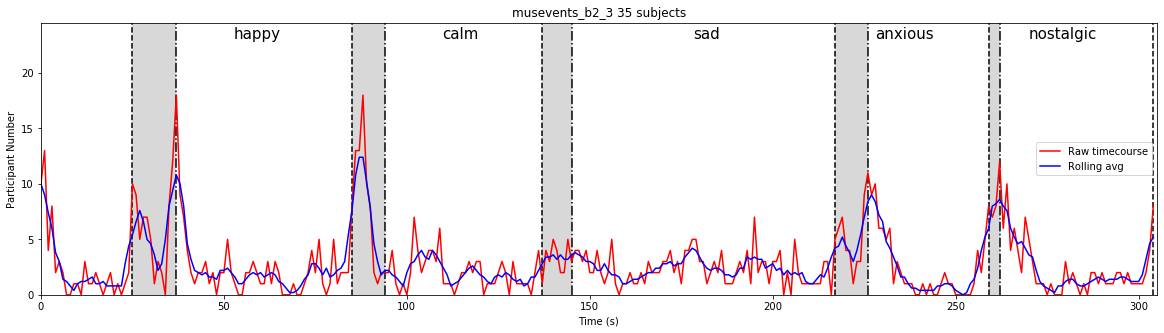

In [3]:
fullcounta1 = 0
fullcountb1 = 0
fullcounta2 = 0
fullcountb2 = 0
events_within_clip = {}
N = 8 #for rolling average
for studyc, study in enumerate(studynames):
    events_within_clip[study] = {}
    bcut = cuts[studyc]
    if (studyc+1) % 3 == 0 and studyc != 0:
        acut = fulldur
    else:
        acut = cuts[studyc+1]
    dur = int(spart_lens[studyc])
    nsubs = len(outdic[study].keys())
    allsub_events = np.zeros((dur,nsubs))
    allsub_emos = np.empty((dur,nsubs), dtype=object)
    allsub_onsets = np.empty((dur,nsubs), dtype=object)
    goodsub = 0
    
    if 'a' in study:
        emoorder = apiece.emo[apiece.studyname == study].to_list()
    elif 'b' in study:
        emoorder = bpiece.emo[bpiece.studyname == study].to_list()
        
    for scount,s in enumerate(outdic[study].keys()):
        tons = []
        if s in remove_list:
            continue
        goodsub += 1
        #print(studyc,study,s)
        df = outdic[study][s]
        subevents = np.zeros((dur))
        subemos = np.empty((dur), dtype=object)
        subonsets = np.empty((dur), dtype=object)

        for i, j in df.iterrows():
            ton = int(float(j[0]))
            if ton > dur:
                break
            if ton in tons: 
                if subonsets[ton-1] == 'On' and j[2] == 'Off': #if second if off and first is on, do not replace, all other examples, you replace
                    continue
                #print(scount,ton,subemos[ton-1],j[1],subonsets[ton-1],j[2])
            tons.append(ton)
            subevents[ton-1] = 1
            subemos[ton-1] = j[1] #if one goes on and one goes off at the same time, the second will be put here
            subonsets[ton-1] = j[2]
        
        allsub_events[:,goodsub-1] = subevents
        allsub_emos[:,goodsub-1] = subemos
        allsub_onsets[:,goodsub-1] = subonsets
        #print(scount,s,study,dur,ton,j[0],j[1],j[2])
    #Sum across and plot results
    allsub_events = allsub_events[:,range(goodsub)]
    allsub_emos = allsub_emos[:,range(goodsub)]
    allsub_onsets= allsub_onsets[:,range(goodsub)]
    
    #plot transition points 
    if 'a1' in study:
        transon = apiece.onset[0:16].values
        transof = apiece.offset[0:16].values
        fullcounta1 += dur
        events_within_clip[study]['transits'] = transitions_a1
    elif 'a2' in study:
        transon = apiece.onset[16:32].values
        transof = apiece.offset[16:32].values
        fullcounta2 += dur
        events_within_clip[study]['transits'] = transitions_a2
    elif 'b1' in study:
        transon = bpiece.onset[0:16].values
        transof = bpiece.offset[0:16].values
        fullcountb1 += dur
        events_within_clip[study]['transits'] = transitions_b1
    elif 'b2' in study:
        transon = bpiece.onset[16:32].values
        transof = bpiece.offset[16:32].values
        fullcountb2 += dur
        events_within_clip[study]['transits'] = transitions_b2
    
    #print(studyc,study,dur,int(spart_lens[(studyc-1)]))
    if studyc == 0 or studyc == 3 or studyc == 6 or studyc == 9:
        dur_pre = 0 
    else:
        dur_pre += int(spart_lens[studyc-1])
    
    trans_on = [elem for elem in transon if bcut <= elem <= acut]
    trans_off = [elem for elem in transof if bcut <= elem <= acut]
    events_within_clip[study]['onset'] = [int(round(elem-bcut)) for elem in trans_on] 
    events_within_clip[study]['offset'] = [int(round(elem-bcut)) for elem in trans_off] 
    events_within_clip[study]['nsubs'] = goodsub
        
    print(studyc,study,dur,dur_pre,nsubs,goodsub,trans_on,trans_off,events_within_clip[study]['onset'],events_within_clip[study]['offset'])
    
    tc = allsub_events.sum(axis = 1)
    events_within_clip[study]['sum'] = tc
        #rolling average of N samples     
    tc_avg = uniform_filter1d(tc, size=5)
    plt.figure(figsize=(20,5))
    plt.title('%s %d subjects' %(study,goodsub))
    x = np.arange(0,dur)
    plt.plot(x,tc,'r', label = 'Raw timecourse')
    plt.plot(x,tc_avg,'b', label = 'Rolling avg')
    plt.vlines(events_within_clip[study]['onset'],ymin = 0, ymax = goodsub,color='k',linestyles = 'dashdot')
    plt.vlines(events_within_clip[study]['offset'],ymin = 0, ymax = goodsub,color='k',linestyles = 'dashed')
    plt.xlim([0,dur])
    plt.ylim([0,goodsub*.7])
    plt.xlabel('Time (s)')
    plt.ylabel('Participant Number')
    plt.legend(loc='center right')
    for d,o in enumerate(events_within_clip[study]['onset']):
        #print(d,o,events_within_clip[study]['offset'])
        # get alignment for labels
        if studyc == 0 or studyc == 3 or studyc == 6 or studyc == 9:
            if d < len( events_within_clip[study]['onset'])-1:
                xalign = np.diff(events_within_clip[study]['onset'])[d]/2
            else:
                xalign = ((dur-o)/2)+5
        else:
            if d <= len( events_within_clip[study]['onset'])-2:
                xalign = np.diff(events_within_clip[study]['onset'])[d]/2
            else:
                xalign = ((dur-o)/2)+5
            print(d,o,xalign, o+xalign)
            
        plt.text(o+xalign, goodsub*.7-1, emoorder[d],verticalalignment='center',horizontalalignment='right',fontsize=15) 
        
        #gray out the transition points
        if studyc == 0 or studyc == 3 or studyc == 6 or studyc == 9:
            if d >= len(events_within_clip[study]['onset'])-1:
                continue
            else:
                endmark = events_within_clip[study]['offset'][d]
                xfill = [endmark,events_within_clip[study]['onset'][d+1]]
            #continue
        else:
            xfill = [o,events_within_clip[study]['offset'][d]]
        plt.fill_between(xfill,0,goodsub,facecolor='gray', alpha=.3)
    #plt.savefig('%s/images/%s_allonoff_%dss.png' %(path,study,goodsub),bbox_inches="tight")
    plt.show()


## Get a zstat/pvalue for whether number of raters is greater at transitions

In [10]:
nPerm= 1000
matches = {p:np.zeros(nPerm + 1) for p in pieces}

for studyc, study in enumerate(studynames):
    if studyc == 0 or studyc == 3 or studyc == 6 or studyc == 9:
        ecount = 0
    studyic = study[-4:-2]
    ts = events_within_clip[study]['sum']
    gt_bounds = events_within_clip[study]['offset']
    if '3' in study:
        gt_bounds = gt_bounds[:-1]
    numsec = len(ts)
    #threshold = events_within_clip[study]['transits'][studyc]
    thresholds = events_within_clip[study]['transits'][ecount:ecount+len(gt_bounds)]
    ecount += len(gt_bounds)
    np.random.seed(0)
    gt_lengths = np.diff(np.concatenate(([0],gt_bounds,[numsec])))
    match = np.zeros(nPerm + 1)
    
    for p in range(nPerm + 1):
        gt_bounds = np.cumsum(gt_lengths)[:-1]
        for bb,b in enumerate(gt_bounds):
            t = thresholds[bb]+3 #ADDED THIS ON 02-17 to inlcue a few seconds after the transition as well
            match[p] += ts[b:b+t].mean()
            if math.isnan(ts[b:b+t].mean()):
                print(studyc,study,numsec,b, p)
        match[p] /= len(gt_bounds)
        gt_lengths = np.random.permutation(gt_lengths)
    
    #print(match)
    zstat = (match[0]-np.mean(match[1:]))/np.std(match[1:])
    pval_from_z = stats.norm.sf((zstat)) 
    pval = utils.p_from_null(match[0], match[1:], side = 'right',exact=False, axis=None) #side='right'
    thresh = np.percentile(match[1:], 95)
    print(studyc,study,studyic,match[0],np.mean(match[1:]),thresh,zstat,pval_from_z,pval)
    
    #get the number of events that did not reach the threshold
    gt_bounds = events_within_clip[study]['offset']
    if '3' in study:
        gt_bounds = gt_bounds[:-1]
    for bb,b in enumerate(gt_bounds):
        t = thresholds[bb]+3 #ADDED THIS ON 02-17 to inlcue a few seconds after the transition as well
        reaches = np.where(ts[b:b+t] >= thresh)
        if len(reaches[0]) == 0:
            print(studyc,study,bb,thresh,'did not reach threshold at any point in transition')

    studyidx = [elem for elem in pieces if studyic in elem][0]  
    matches[studyidx] += match
    if studyc == 2 or studyc == 5 or studyc == 8 or studyc == 11:
        matches[studyidx] /= 3
        zstat_full = (matches[studyidx][0] - matches[studyidx][1:].mean())/matches[studyidx][1:].std()
        pval_from_z_full = stats.norm.sf((zstat_full)) #one-sided
        print(studyidx,zstat_full,pval_from_z_full)

0 musevents_a1_1 a1 3.6 2.6276 3.366666666666667 2.632181881446992 0.004241921587594138 0.002997002997002997
1 musevents_a1_2 a1 3.961111111111112 2.1246 3.2008333333333323 3.208393281782606 0.0006673941779980184 0.002997002997002997
2 musevents_a1_3 a1 2.855555555555555 2.08465 2.8783333333333325 1.683449201736305 0.04614408266657057 0.060939060939060936
a1 3.611262424314524 0.00015235507014403334
3 musevents_a2_1 a2 5.3500000000000005 3.192945238095238 5.097619047619047 2.3149512316682963 0.010307800574611697 0.007992007992007992
4 musevents_a2_2 a2 3.742424242424242 2.4810212121212123 3.7045454545454546 1.885373218998771 0.029689733555679703 0.04695304695304695
5 musevents_a2_3 a2 3.444444444444444 1.9541000000000002 3.3 2.5844594234935254 0.004876589001460602 0.022977022977022976
5 musevents_a2_3 3 3.3 did not reach threshold at any point in transition
a2 3.2229363938283293 0.0006344186284010265
6 musevents_b1_1 b1 4.403333333333333 2.8022933333333335 4.17 2.1322476332338387 0.0164

## Convert df to wide with onset and offset then average each emotions separately 

0 musevents_a1_1 [0, 69, 132, 192, 249, 306] [60, 123, 183, 240, 297] 36 6 5 6


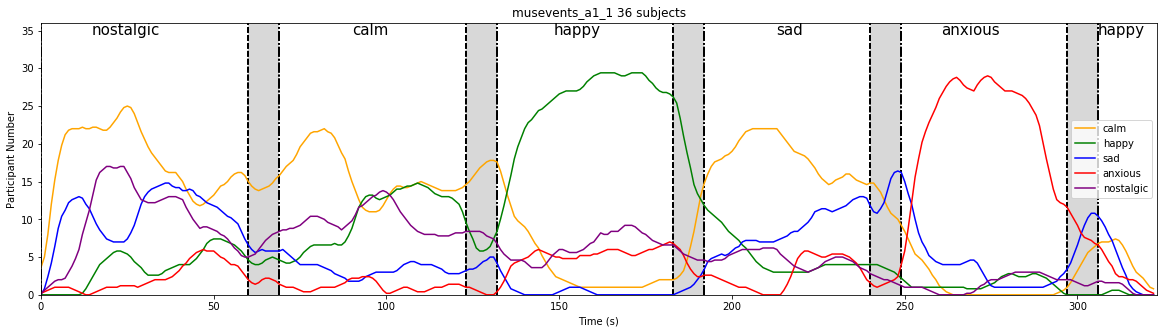

1 musevents_a1_2 [42, 93, 159, 201, 246] [36, 84, 150, 198, 237] 36 5 5 5


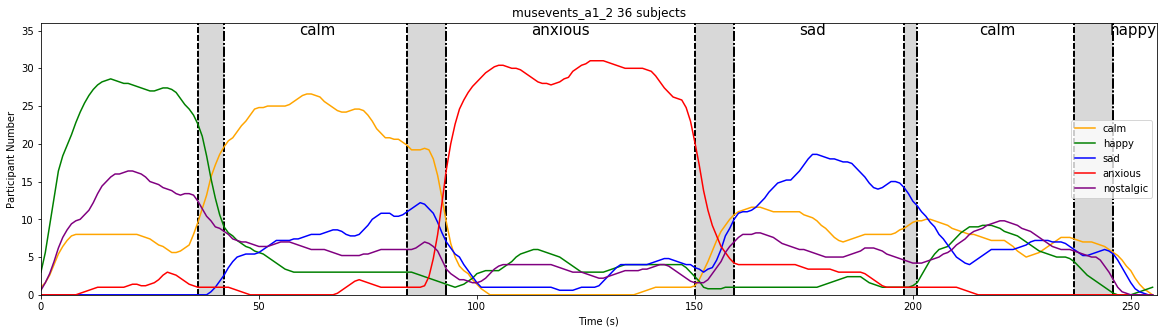

2 musevents_a1_3 [47, 104, 149, 194, 254] [38, 95, 143, 188, 245, 314] 36 5 6 5


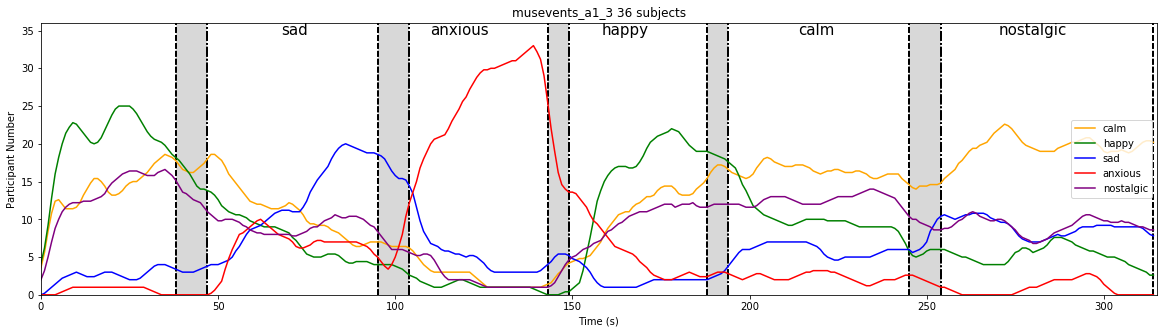

3 musevents_a2_1 [0, 69, 129, 192, 234, 300] [60, 120, 181, 231, 291] 36 6 5 6


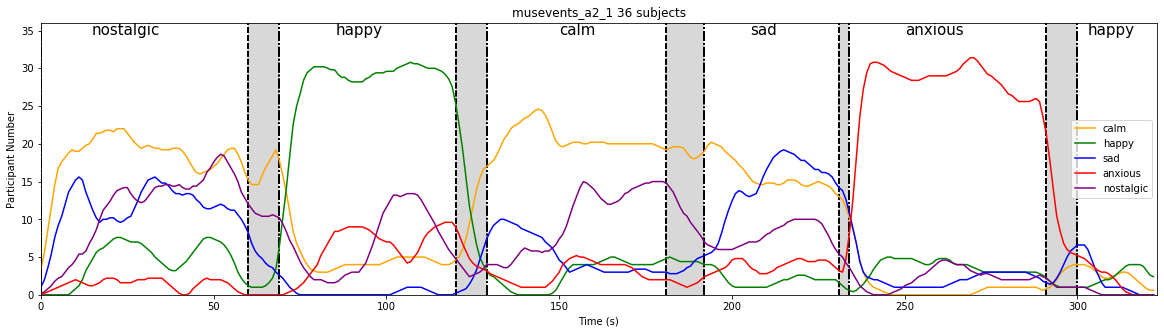

4 musevents_a2_2 [34, 79, 124, 181, 232] [25, 70, 118, 173, 223] 36 5 5 5


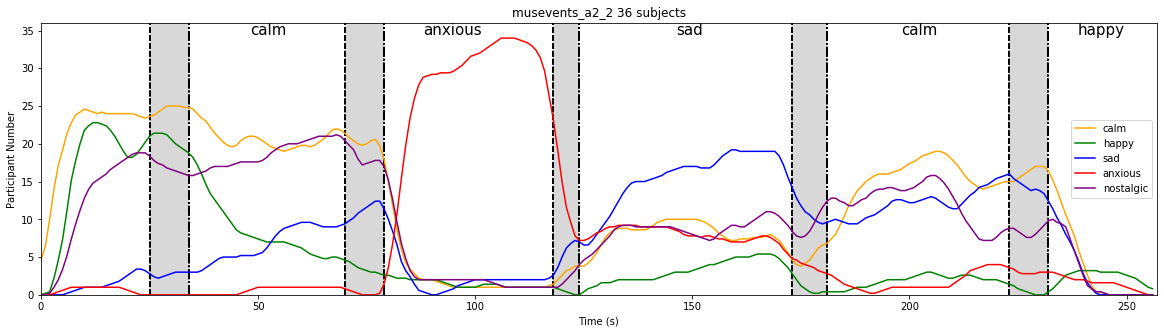

5 musevents_a2_3 [35, 92, 149, 209, 254] [29, 83, 140, 200, 248, 314] 36 5 6 5


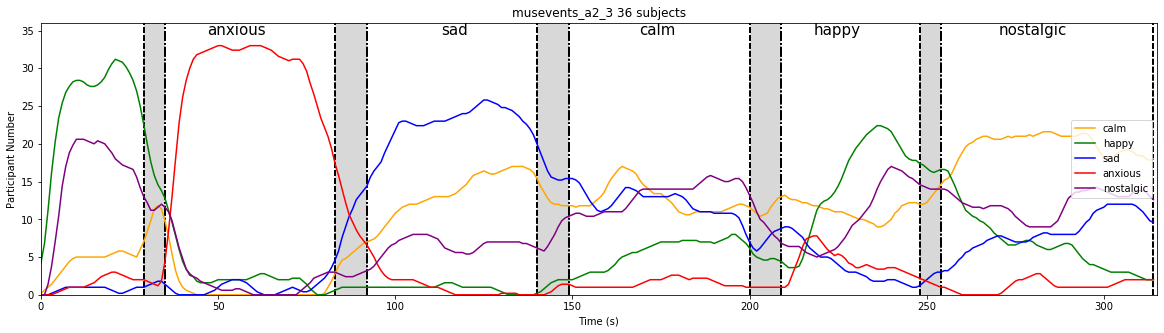

6 musevents_b1_1 [0, 45, 102, 159, 219, 279] [36, 93, 150, 210, 267] 35 6 5 6


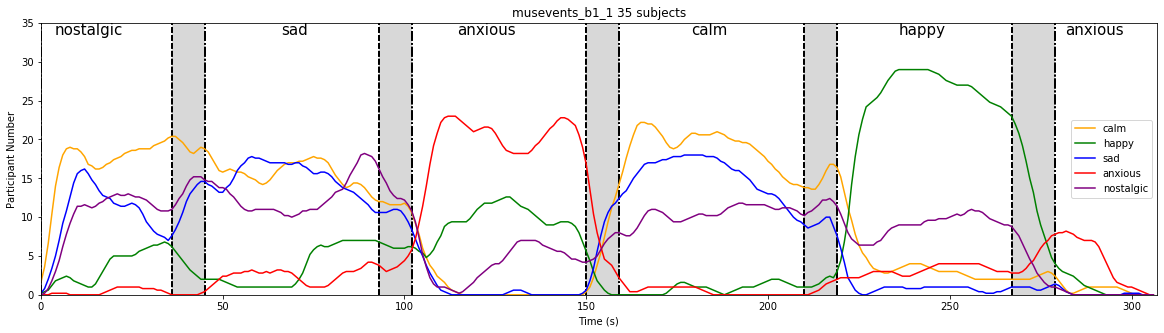

7 musevents_b1_2 [28, 91, 127, 202, 259] [19, 82, 118, 193, 250] 35 5 5 5


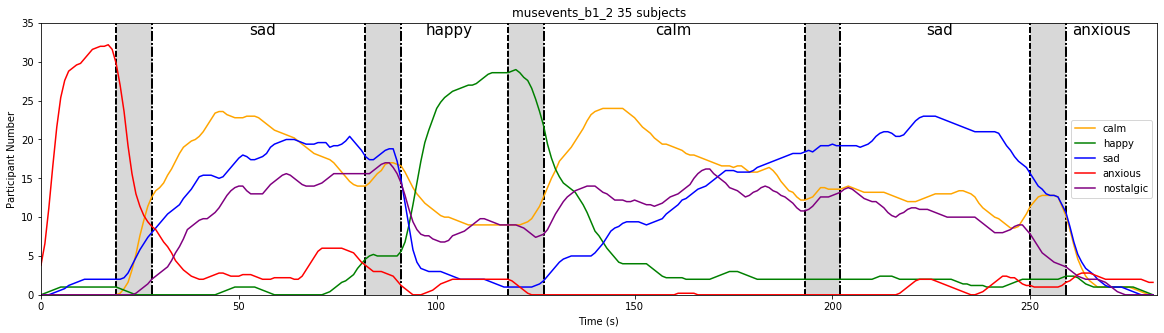

8 musevents_b1_3 [34, 88, 145, 181, 262] [25, 82, 136, 175, 253, 304] 35 5 6 5


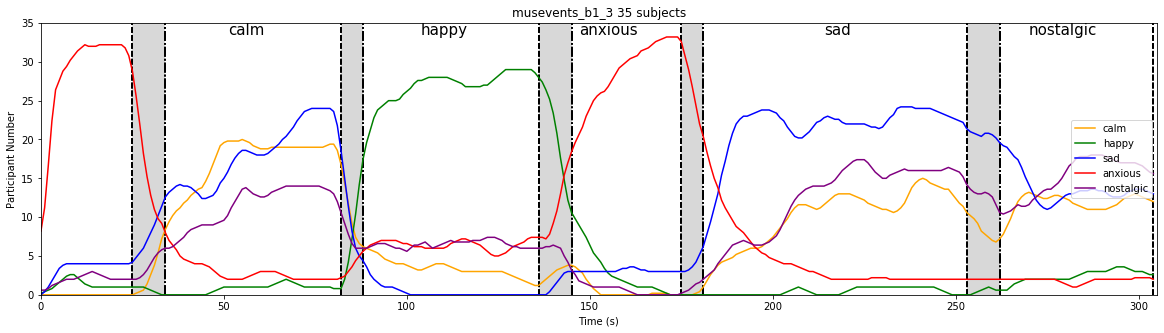

9 musevents_b2_1 [0, 45, 102, 159, 219, 279] [36, 93, 150, 210, 270] 35 6 5 6


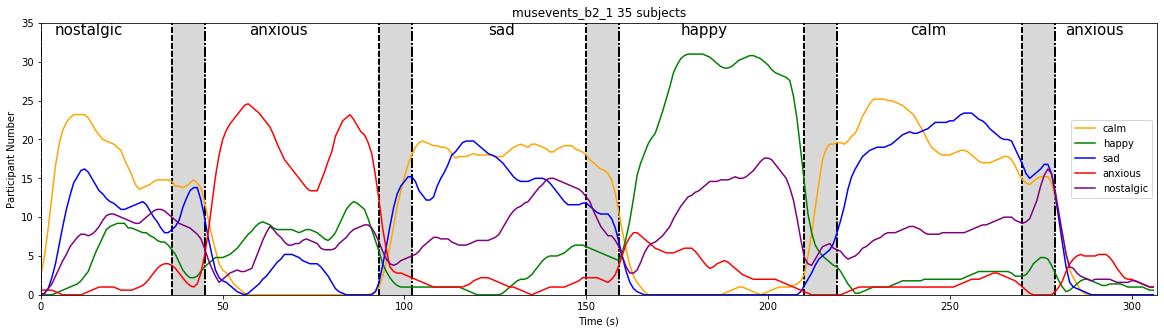

10 musevents_b2_2 [29, 86, 161, 197, 260] [20, 77, 152, 188, 251] 35 5 5 5


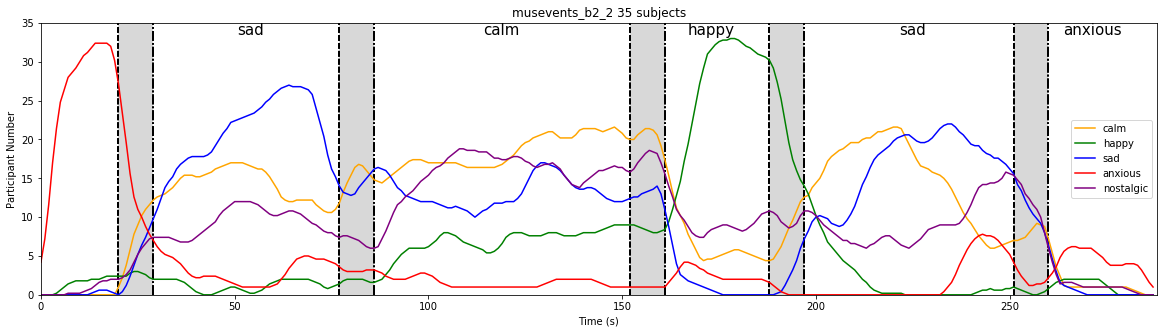

11 musevents_b2_3 [37, 94, 145, 226, 262] [25, 85, 137, 217, 259, 304] 35 5 6 5


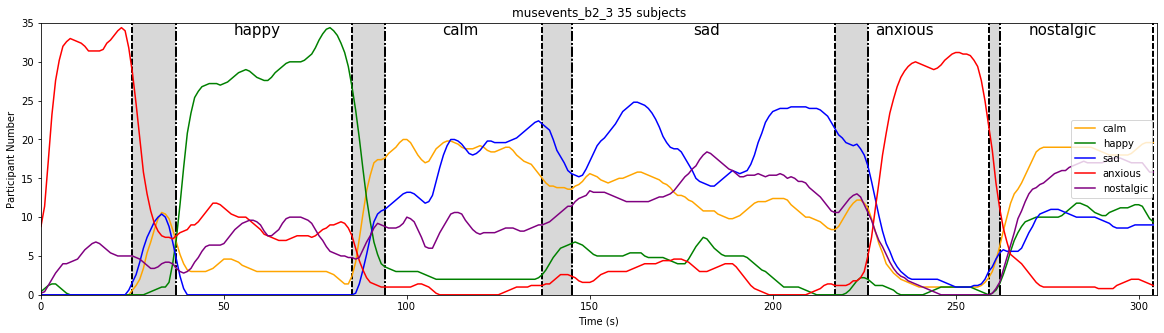

In [12]:
all_emo_events = {}
emo_events = {}
for studyc, study in enumerate(studynames):
    dur = int(spart_lens[studyc])
    if 'a' in study:
        emoorder = apiece.emo[apiece.studyname == study].to_list()
    elif 'b' in study:
        emoorder = bpiece.emo[bpiece.studyname == study].to_list()
    nsubs = events_within_clip[study]['nsubs']
    goodsub = 0
    goodsublist = []
    all_emo_events[study] = {e:np.zeros((dur,nsubs)) for e in emos}
    emo_events[study] = {e:np.zeros((dur)) for e in emos}
    onsets = events_within_clip[study]['onset']
    offsets = events_within_clip[study]['offset']
    print(studyc,study,onsets,offsets,nsubs,len(onsets),len(offsets),len(emoorder))
        
    answers = np.zeros((len(outdic[study].keys()),len(emos)))
    for scount,s in enumerate(outdic[study].keys()):
        if s in remove_list:
            continue
        goodsub += 1
        goodsublist.append(s)
        df = outdic[study][s]
        np_wide = np.empty((df.shape[0],6),dtype = 'object')
        count = 0
        for i, j in df.iterrows():
            if j[2] == 'On':
                emo = j[1]
                for i2, j2 in df.iloc[i:].iterrows():
                    if j2[2] == 'Off' and j2[1] == emo or j2[1] == 'All': #and (float(j[0]) < float(j2[0]))
                        count += 1
                        #print(count,[j[0],j[1],j[2],j2[0],j2[1],j2[2]])
                        np_wide[count-1,:] = np.array([j[0],j[1],j[2],j2[0],j2[1],j2[2]])
                        break
        df_wide = pd.DataFrame(np_wide[0:count])

        for k, h in df_wide.iterrows():
            eidx = emos.index(h[1])
            start = math.floor((float(h[0]))) #floor because anything between 2-3s should be in cell 2
            if start > dur:
                continue
            end = math.floor((float(h[3])))
            if end > dur:
                end = dur
            try:
                emo_events[study][emos[eidx]][start:end] += np.repeat(1,(end-start))
                all_emo_events[study][emos[eidx]][start:end,goodsub-1] = np.repeat(1,(end-start))
            except ValueError:
                print('Value error:',eidx,emos[eidx],dur,start,end)
    #all_emo_events[study][emos[eidx][:,scount] = all_emo_events[study][emos[eidx][:,0:goodsub]
    
    plt.figure(figsize=(20,5))  
    #colors = {'calm':'orange', 'sad':'blue', 'happy':'green', 'notalgia':'purple','anxious':'red'}
    colors = ['orange', 'green', 'blue','red','purple']
    for it,e in enumerate(emos):
        y = emo_events[study][e]
        y_smooth = uniform_filter1d(y, size=5)
        #avg_emo_events = np.count_nonzero(all_emo_events,axis = 1)/nsubs
        x = np.arange(0,dur)
        plt.plot(x,y_smooth,color = colors[it],label = e)
        plt.xlim([0,dur])
        plt.ylim([0,nsubs])
        plt.xlabel('Time (s)')
        plt.ylabel('Participant Number')
        plt.legend(loc='center right')
        plt.title('%s %d subjects' %(study,goodsub))
        plt.vlines(onsets,ymin = 0, ymax = goodsub,color='k',linestyles = 'dashdot')
        plt.vlines(offsets,ymin = 0, ymax = goodsub,color='k',linestyles = 'dashed') 
    for d,o in enumerate(onsets):
        if studyc == 0 or studyc == 3 or studyc == 6 or studyc == 9:
            if d < len(onsets)-1:
                xalign = np.diff(events_within_clip[study]['onset'])[d]/2
            else:
                xalign = ((dur-o)/2)+5
        else:
            if d <= len(onsets)-2:
                xalign = np.diff(events_within_clip[study]['onset'])[d]/2
            else:
                xalign = ((dur-o)/2)+5
            
        plt.text(o+xalign, goodsub-1, emoorder[d],verticalalignment='center',horizontalalignment='right',fontsize=15) 
        
        if studyc == 0 or studyc == 3 or studyc == 6 or studyc == 9:
            if d == len(onsets)-1:
                continue
            else:
                endmark = events_within_clip[study]['offset'][d]
                xfill = [endmark,events_within_clip[study]['onset'][d+1]]
            #continue
        else:
            xfill = [o,events_within_clip[study]['offset'][d]]
        plt.fill_between(xfill,0,goodsub,facecolor='gray', alpha=.3)
        
    plt.savefig('%s/images/%s_emo_sum_ons_%dss.png' %(path,study,goodsub),bbox_inches="tight")
    plt.show()
    
    all_emo_events[study]['sublist'] = goodsublist

# #phase shift and plot 
# #avg_emo_events_phase = brainiak.utils.utils.phase_randomize(avg_emo_events_conv, voxelwise=False, random_state=None)

fname = path + '/emo_sums_36ss_03-18'
if not os.path.exists(fname):
    dd.io.save(fname,emo_events)
 

## Calculate time to peak for all emotions and get ratings(5) x event (16) x subject matrix

#### allsub_emo_temp_ratings ratings(5) x event (16) x subject
#### allsub_emo_temp_ratings = {} # for each study, ratings(5) x event (16) x subject

In [51]:
diff_times = ['Horror','AQuietCity','Starshine','CloudWalking','AloneAtSea']
diff_minlen = [30,43,48,52,48]
peak_results = np.empty((4*clipcount,12),dtype = 'object')
counter = -1
#allemo_event_ratings = {}
allemo_event_ratings = np.zeros((len(emos),clipcount*4))  #ratings(5) x event (64) #MEAN ACROSS PEOPLE
allsub_emo_event_ratings = {} # for each study, ratings(5) x event (16) x subject
allsub_emo_temp_ratings = {} # for each study, ratings(5) x event (16) x subject

for studyc, study in enumerate(studynames):
    dur = int(spart_lens[studyc])
    if 'a' in study:
        emoorder = apiece.emo[apiece.studyname == study].to_list()
        clipnames = apiece.nickname[apiece.studyname == study].to_list()
        conditions = apiece.condition[apiece.studyname == study].to_list()
        cons2 = apiece.con2[apiece.studyname == study].to_list()
        cons3 = apiece.con3[apiece.studyname == study].to_list()
        #allsub_emo_event_ratings['a'] = np.zeros((len(emos),clipcount*4))
    elif 'b' in study:
        emoorder = bpiece.emo[bpiece.studyname == study].to_list()
        clipnames = bpiece.nickname[bpiece.studyname == study].to_list()
        conditions = bpiece.condition[bpiece.studyname == study].to_list()
        cons2 = bpiece.con2[bpiece.studyname == study].to_list()
        cons3 = bpiece.con3[bpiece.studyname == study].to_list()
        
        #allsub_emo_event_ratings['b'] = np.zeros((len(emos),clipcount*4))

    piece = study.split('_')[1][0]
    version = study.split('_')[1][1]
    onsets = events_within_clip[study]['onset']
    offsets = events_within_clip[study]['offset']
    nsub = len(all_emo_events[study]['sublist'])
    allsub_emo_event_ratings[study] = np.zeros((len(emos),len(emoorder),len(all_emo_events[study]['sublist']))) # for each study, ratings(5) x event (5-6) x subject
        
    for i,e in enumerate(emoorder):
        counter += 1
        on = onsets[i]
        clipname = clipnames[i]

        condition = conditions[i]
        con2 = cons2[i]
        con3 = cons3[i]
        if len(offsets) > len(onsets): #this means we're at the third clip
            off = offsets[i+1]
        elif len(offsets) == len(onsets): #this means we're on the second clip
            if i != len(emoorder)-1:
                #on == onsets[i-1]
                off = offsets[i+1]
            else:
                study = studynames[studyc+1] #means we're on the last clip
                on = 0 
                off = events_within_clip[study]['offset'][0]
                #continue #if we are at the end of the second clip, move on and take it from the next 
                #off = dur
        else:                             #this means we're on the first clip? 
            if i != len(emoorder)-1:
                #on == onsets[i-1]
                off = offsets[i]
            else:
                study = studynames[studyc+1] #means we're on the last clip
                on = 0 
                off = events_within_clip[study]['offset'][0]
                #continue #if we are at the end of the first clip, move on and take it from the next
                #off = dur
        #add it so that if we are at the end of a cut, it takes the time to peak from the start of the next clip
        print(studyc,study,i,e,clipname,version,on,off,off-on,'secs')
        emo_rate_sum = emo_events[study][e][on:off]

        try:
            allsub_emo_temp_ratings[clipname]
        except KeyError: 
            allsub_emo_temp_ratings[clipname] = {}
            
        #Don't calculate peak if the max is less than 30% of people
        if max(emo_rate_sum[2:]) < nsub*.3:
            print(study,e,clipname,max(emo_rate_sum[2:]),'TOO FEW')
        else:
            peak = np.where(emo_rate_sum > .9*max(emo_rate_sum[2:]))[0] #change this to when it first reaches 90% of max (also check to make sure it's after the first second)
            num_at_peak = emo_rate_sum[peak][0]
            print('TIME TO PEAK:',study,clipcount,e,clipname,con2,con3,on,off,emo_rate_sum.shape,'secs:',peak[0],'number:',num_at_peak)
            peak_results[counter,:] = study,piece,version,condition,e,clipname,on,off,peak[0],num_at_peak,con2,con3
        
        #get a emo rating x event dataframe
        if clipname in diff_times:
            tps = diff_minlen[diff_times.index(clipname)]
            off = on + tps
            print(studyc,study,i,e,clipname,on,off,off-on,'secs')
        else:
            tps = off-on
        allsub_emo_temp_ratings[clipname][version] = np.zeros(((off-on)*len(emos),len(all_emo_events[study]['sublist'])))
        temp = np.zeros((off-on,len(emos)))
        temp2 = np.zeros((off-on,len(emos),len(all_emo_events[study]['sublist'])))
        temp3 = np.zeros(((off-on)*len(emos),len(all_emo_events[study]['sublist'])))
        for ii,ee in enumerate(emos):
            temp[:,ii] = emo_events[study][ee][on:off]
            temp2[:,ii,:] = all_emo_events[study][ee][on:off] #temp 2 is length of event x 5 emo ratings, by subject
            temp3[(ii*tps):(ii*tps)+tps,:] = all_emo_events[study][ee][on:off] #temp 3 is length of event x 5 emo ratings, by subject
        
        allemo_event_ratings[:,counter] = temp.mean(axis = 0)
        study = studynames[studyc] #CONVERT BACK SO THAT IT IS PLACED IN ITS ORIGINAL LOCATION
        allsub_emo_event_ratings[study][:,i,:] = temp2.mean(axis = 0) #so the mean is the five ratings averaged time for each person
        
        allsub_emo_temp_ratings[clipname][version][:,:] = temp3 #DO NOT AVERAGE ACROSS TIME (NEW 02-17)

df_peak= pd.DataFrame(peak_results)
df_peak.columns = ['study','piece','version','condition','emo','clipname','onset','offset','secs2peak','peak_height','con2','con3']

0 musevents_a1_1 0 nostalgic DorianWalk 1 0 60 60 secs
TIME TO PEAK: musevents_a1_1 16 nostalgic DorianWalk nan nan 0 60 (60,) secs: 17 number: 17.0
0 musevents_a1_1 1 calm CloudWalking 1 69 123 54 secs
TIME TO PEAK: musevents_a1_1 16 calm CloudWalking 0.0 N 69 123 (54,) secs: 7 number: 21.0
0 musevents_a1_1 1 calm CloudWalking 69 121 52 secs
0 musevents_a1_1 2 happy FrogCatching 1 132 183 51 secs
TIME TO PEAK: musevents_a1_1 16 happy FrogCatching 0.0 C 132 183 (51,) secs: 26 number: 28.0
0 musevents_a1_1 3 sad Tether 1 192 240 48 secs
TIME TO PEAK: musevents_a1_1 16 sad Tether 0.0 J 192 240 (48,) secs: 44 number: 13.0
0 musevents_a1_1 4 anxious IncomingTrain 1 249 297 48 secs
TIME TO PEAK: musevents_a1_1 16 anxious IncomingTrain nan S 249 297 (48,) secs: 13 number: 28.0
0 musevents_a1_2 5 happy SnowDay 1 0 36 36 secs
TIME TO PEAK: musevents_a1_2 16 happy SnowDay 1.0 A 0 36 (36,) secs: 11 number: 27.0
1 musevents_a1_2 0 calm Calm 1 42 84 42 secs
TIME TO PEAK: musevents_a1_2 16 calm Cal

## Permutation testing for time to peak 

In [103]:
df_peak = df_peak[df_peak.astype(str).ne('None').all(1)]
df_peak.secs2peak = df_peak.secs2peak.astype(int)
df_peak.peak_height = df_peak.peak_height.astype(int)
df_sort = df_peak.sort_values(['piece', 'clipname','version'], ascending=[True, True,True])

df_sort.groupby('con2')['secs2peak'].mean()
df_sort.groupby('con3')['secs2peak'].mean()

notin = ['FrogCatching','CloudWalking','Twister','Willow'] #first four because they were not heard in differnt ways (came after nostalgic)
df_rm = df_sort[df_sort.emo != 'nostalgic']
df_rm = df_rm[~df_rm.clipname.isin(notin)]
df_rm.groupby('emo')['secs2peak'].agg(['mean', 'std','count']).round(2)

df_rm.groupby(['condition','emo'])['secs2peak'].agg(['mean', 'std','count']).round(2)
df_rm.groupby('con2')['secs2peak'].agg(['mean', 'std','count']).round(2) #looks like time to peak is affected by being proceeded by anxoius 
df_rm.groupby('con3')['secs2peak'].agg(['mean', 'std','count']).round(2) #looks like time to peak is affected by being proceeded by anxoius 


##PERMUTE THE CONDITION
nn, nps, pn, pp = df_rm.groupby(['condition'])['secs2peak'].agg(['count']).values

cons = conditions[:-1] #get rid of NAN
nPerm = 5000
times2peak = {c:np.zeros(nPerm+1) for c in cons}
df_sorted = df_rm.sort_values('condition')
indx_neg = df_sorted.index[(df_sorted['condition'] == 'NN') | (df_sorted['condition'] == 'PN')].to_list()
indx_pos = df_sorted.index[(df_sorted['condition'] == 'PP') | (df_sorted['condition'] == 'NP')].to_list()
print('Permuting',nPerm,'times...')
for n in range(nPerm+1):

    #negs = df_sorted.loc[indx_neg].sort_values('clipname')
    negs = df_sorted.loc[indx_neg].secs2peak
    pos = df_sorted.loc[indx_pos].secs2peak

    times2peak['NN'][n] = negs[0:nn[0]].mean()
    times2peak['PN'][n] = negs[nn[0]:nn[0]+pn[0]].mean()
    times2peak['NP'][n] = pos[0:nps[0]].mean()
    times2peak['PP'][n] = pos[nps[0]:nps[0]+pp[0]].mean()

    indx_pos = np.random.permutation(indx_pos)
    indx_neg = np.random.permutation(indx_neg)
print('FINISHED')

print('NN','time in secs:',times2peak['NN'][0],'PN',times2peak["PN"][1:].mean())
print('PP','time in secs:',times2peak['PP'][0],'NP',times2peak["NP"][1:].mean())

negdiffs = times2peak['PN']-times2peak['NN']
posdiffs = times2peak['NP']-times2peak['PP']

##PERMUTE THE CONDITION3
cons = conditions[:-1] #get rid of NAN
nPerm = 5000
times2peak = {c:np.zeros(nPerm+1) for c in cons}
df_sorted = df_rm.sort_values('con3')
indx_neg = df_sorted.index[(df_sorted['con3'] == 'NN') | (df_sorted['con3'] == 'PN')].to_list()
indx_pos = df_sorted.index[(df_sorted['con3'] == 'PP') | (df_sorted['con3'] == 'NP')].to_list()
print('Permuting',nPerm,'times...')
for n in range(nPerm+1):

    negs = df_sorted.loc[indx_neg].secs2peak
    pos = df_sorted.loc[indx_pos].secs2peak

    times2peak['NN'][n] = negs[0:12].mean()
    times2peak['PN'][n] = negs[12:24].mean()
    times2peak['NP'][n] = pos[0:12].mean()
    times2peak['PP'][n] = pos[12:24].mean()
    
    #times2peak['NP'][n] = pos.groupby('condition')['secs2peak'].mean()[0]
    #times2peak['PN'][n] = negs.groupby('condition')['secs2peak'].mean()[1]

    indx_pos = np.random.permutation(indx_pos)
    indx_neg = np.random.permutation(indx_neg)
print('FINISHED')



zstat = (negdiffs[0]-np.mean(negdiffs[1:]))/np.std(negdiffs[1:])
pval_from_z = stats.norm.sf((zstat)) 
pval = utils.p_from_null(negdiffs[0], negdiffs[1:], side = 'right',exact=False, axis=None) #side='right'
print('NEG',negdiffs[0],np.mean(negdiffs[1:]),'zstat:',zstat,'p from z:',pval_from_z,pval)

zstat = (posdiffs[0]-np.mean(posdiffs[1:]))/np.std(posdiffs[1:])
pval_from_z = stats.norm.sf((zstat)) 
pval = utils.p_from_null(posdiffs[0], posdiffs[1:], side = 'right',exact=False, axis=None) #side='right'
print('POS',posdiffs[0],np.mean(posdiffs[1:]),'zstat:',zstat,'p from z:',pval_from_z,pval)

Permuting 5000 times...
FINISHED
NN time in secs: 16.75 PN 17.10748333333333
PP time in secs: 9.5 NP 13.010916666666667
NEG 0.75 -0.03503333333333334 zstat: 0.17722335148363372 p from z: 0.4296664770733996 0.4321135772845431
POS 7.166666666666668 -0.14483333333333334 zstat: 1.7818636678089101 p from z: 0.03738573331108316 0.03939212157568486


## For each event, get the max of the ratings and see how many match the intended with permutation testing

In [17]:
#for each event, get the max of the ratings and see how many match the intended
categ_rate_perm = np.zeros((len(emos),nPerm+1))

#loop through each event and find which emotion was the max rating
for enum in range(allemo_event_ratings.shape[1]):
    allemos = fulltrans.emo.values
    for p in range(nPerm+1):
        maxrate = np.where(allemo_event_ratings == max(allemo_event_ratings[:,enum]))[0][0]
        maxemo = emos[maxrate]
        emo_intend = allemos[enum]
        corr_sum = allemo_event_ratings[emos.index(emo_intend),enum] #get the 
        categ_rate_perm[emos.index(emo_intend),p] += corr_sum
        allemos = np.random.permutation(allemos)
        if p == 0:
            if maxemo != emo_intend:
                print(enum,fulltrans.iloc[enum].studyname,fulltrans.iloc[enum].nickname,maxemo,max(allemo_event_ratings[:,enum]),emo_intend,corr_sum)

for i,e in enumerate(emos):
    diffs = categ_rate_perm[i,:] / len(np.where(allemos == e)[0])
    zstat = (diffs[0]-np.mean(diffs[1:]))/np.std(diffs[1:])
    pval_from_z = stats.norm.sf((zstat)) 
    pval = utils.p_from_null(diffs[0], diffs[1:], side = 'right',exact=False, axis=None) #side='right'
    print(i,e,round(diffs[0],3),round(diffs[1:].mean(),3),zstat,round(pval_from_z,3),round(pval,3))
    

0 musevents_a1_1 DorianWalk calm 17.7 nostalgic 9.833333333333334
3 musevents_a1_1 Tether calm 18.291666666666668 sad 8.583333333333334
5 musevents_a1_1 SnowDay calm 23.833333333333332 happy 23.833333333333332
15 musevents_a1_3 Tangerine calm 19.533333333333335 nostalgic 9.216666666666667
16 musevents_a2_1 DorianWalk calm 18.316666666666666 nostalgic 11.4
19 musevents_a2_1 Slugs calm 16.076923076923077 sad 14.384615384615385
21 musevents_a2_1 Breeze calm 20.96 happy 15.6
29 musevents_a2_3 PinkSchooner nostalgic 13.215686274509803 calm 12.745098039215685
31 musevents_a2_3 Tangerine calm 19.816666666666666 nostalgic 12.083333333333334
32 musevents_b1_1 ToyTrucks calm 16.61111111111111 nostalgic 9.833333333333334
33 musevents_b1_1 Willow calm 15.791666666666666 sad 15.208333333333334
38 musevents_b1_2 Abstraction calm 19.25925925925926 sad 16.685185185185187
43 musevents_b1_3 AQuietCity sad 17.41860465116279 calm 17.023255813953487
48 musevents_b2_1 ToyTrucks calm 17.22222222222222 nostal

## How similar are ratings across emotions  for same clips versus different clips of the same category

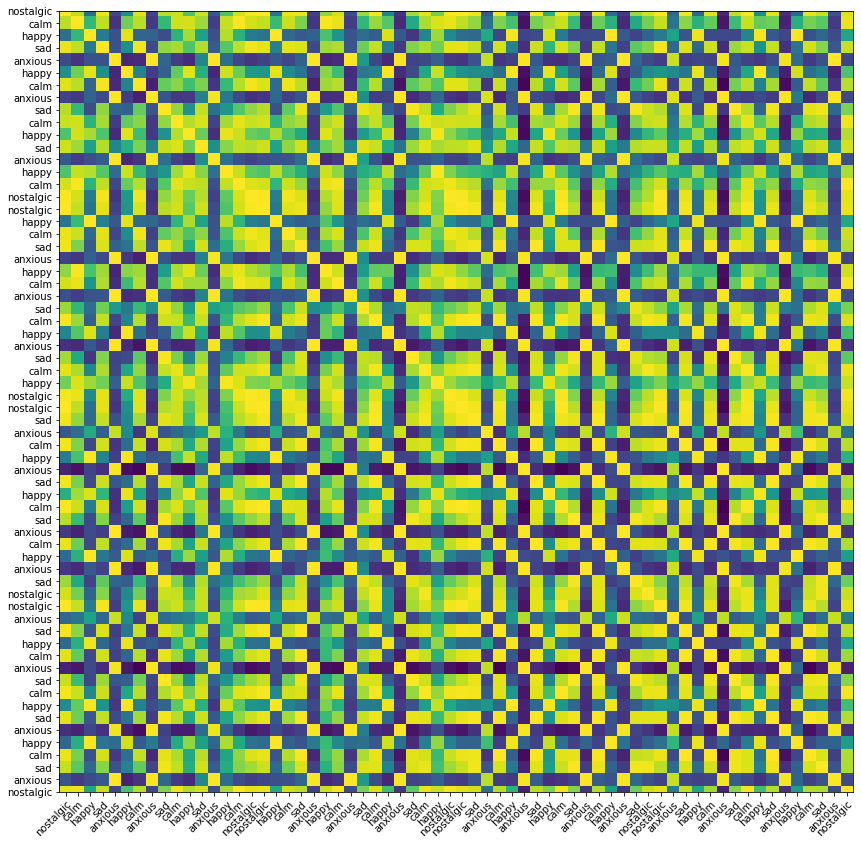

Text(3.200000000000003, 0.5, 'Event Emotion')

In [52]:
#get behavioral correlation matrix
rating_cosmat = cosine_similarity(allemo_event_ratings.T)
f, ax = plt.subplots(1,1, figsize = (12,12))
im = ax.imshow(rating_cosmat, cmap='viridis')

# We want to show all ticks...
alleventlist = apiece.emo.to_list()
alleventlist.extend((bpiece.emo.to_list()))
allnamelist = apiece.nickname.to_list()
allnamelist.extend((bpiece.nickname.to_list()))

ax.set_xticks(np.arange(len(alleventlist)))
ax.set_yticks(np.arange(len(alleventlist)))
# ... and label them with the respective list entries
ax.set_xticklabels(alleventlist)
ax.set_yticklabels(alleventlist)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
#ax.set_title("Harvest of local farmers (in tons/year)")
f.tight_layout()
plt.show()
ax.set_xlabel('Event Emotion')
ax.set_ylabel('Event Emotion')

## Compare ratings by condition with ISC (considering both temporal and multivariate components by concatenating in time)

In [55]:
nPerm = 1000
#notin = ['FrogCatching','CloudWalking','Twister','Willow','SnowDay','Breeze','ColdWar','ParanoidInMacys'] #first four because they were not heard in differnt ways, second four because they cross clips
notin = ['SnowDay','Breeze','ColdWar','ParanoidInMacys'] #first four because they were not heard in differnt ways, second four because they cross clips

#but ParanoidInMacys, Snowday and Breeze were cut in both so we could take the second time they heard them
isc_results = np.empty((2*14-len(notin),8),dtype = 'object')
withincon_corrs = np.zeros((2*14-len(notin),nPerm+1))
acrosscon_corrs = np.zeros((2*14-len(notin),nPerm+1))


for pcount,p in enumerate(['a','b']):
    if p =='a':
        emoorder = apiece.emo.to_list()
        clipnames = apiece.nickname.to_list()
        conditions = apiece.condition.to_list()
        conditions2 = apiece.con2.to_list()
        conditions3 = apiece.con3.to_list()
        nhalf = 18
        totaln = nhalf*2*2
    elif p =='b':
        emoorder = bpiece.emo.to_list()
        clipnames = bpiece.nickname.to_list()
        conditions = bpiece.condition.to_list()
        conditions2 = bpiece.con2.to_list()
        conditions3 = bpiece.con3.to_list()
        nhalf = 17
        totaln = 70

    indices = np.arange(totaln)
    for perm in range(nPerm+1):
        if p == 'a':
            allcount = 0
        if p == 'b':
            allcount = 12
        #go through each event for piece a or b
        for ecount,event in enumerate(clipnames[0:clipcount]): #for each event, compare the similarity between half people who heard it the same way (same condition) and half of all people who heard it diff
            tps1,wsubnum = allsub_emo_temp_ratings[event]['1'].shape
            tps2,asubnum = allsub_emo_temp_ratings[event]['2'].shape
            if event in notin:
                continue
            if emoorder[ecount] == 'nostalgic':
                continue
            if tps1 != tps2: #they should all be the same length now
                continue
            else:
                e1 = allsub_emo_temp_ratings[event]['1']
                e2 = allsub_emo_temp_ratings[event]['2']

            fullcon = np.concatenate([e1,e2],axis = 1)
            fullcon = fullcon[:,indices]

            wh1 = fullcon[:,0:nhalf]
            wh2 = fullcon[:,nhalf:wsubnum]
            ah1 = fullcon[:,wsubnum:wsubnum+nhalf]
            ah2 = fullcon[:,wsubnum+nhalf:wsubnum+asubnum]
            
            c = -1
            withincon1 = []
            withincon2 = []
            crosscon1  = []
            crosscon2  = []
            crosscon3  = []
            crosscon4  = []
            for i1 in range(nhalf):
                for i2 in range(nhalf):
                    c += 1
                    withincon1.append(isc([wh1[:,i1],wh2[:,i2]])[0])
                    withincon2.append(isc([ah1[:,i1],ah1[:,i2]])[0])
                    crosscon1.append(isc([wh1[:,i1],ah1[:,i2]])[0])
                    crosscon2.append(isc([wh1[:,i1],ah2[:,i2]])[0])
                    crosscon3.append(isc([wh2[:,i1],ah1[:,i2]])[0])
                    crosscon4.append(isc([wh2[:,i1],ah2[:,i2]])[0])

            withincon1 = np.nanmean(withincon1) #mean of an unsymmetric array should be same as half (all pariwise similarity of split half in a1)
            withincon2 = np.nanmean(withincon2) #(all pariwise similarity of split half in a2, i.e. people that all heard it in one context)
            crosscon1 =  np.nanmean(crosscon1)               #NN1-PN1 similarity between half people who heard it in one condition and half who heard it in a different condition
            crosscon2 =  np.nanmean(crosscon2)                #NN2-PN1
            crosscon3 =  np.nanmean(crosscon3)                #NN1-PN2
            crosscon4 =  np.nanmean(crosscon4)               #NN2-PN2
            
            if np.isnan([withincon1, withincon2,crosscon1,crosscon2,crosscon3,crosscon4]).any():
                print('FOUND NAS')
                break

            # mean(NN1-NN2, PN1-PN2) > mean(NN1-PN1, NN1-PN2, NN2-PN1, NN2-PN2) 
            withincon = np.mean([withincon1,withincon2])
            crosscon = np.mean([crosscon1,crosscon2,crosscon3,crosscon4])
            withincon_corrs[allcount,perm] = withincon
            acrosscon_corrs[allcount,perm] = crosscon

            if perm % 100 == 0:   
                print(p,perm,allcount,ecount,emoorder[ecount],conditions[ecount],conditions2[ecount],conditions3[ecount],event,'within:',round(withincon,3),'across:',round(crosscon,3))
                isc_results[allcount,:] = perm,event,emoorder[ecount],conditions[ecount],conditions2[ecount],conditions3[ecount],withincon,crosscon
            allcount += 1

        #permute fullcon
        indices = np.random.permutation(range(totaln))
        
df_isc = pd.DataFrame(isc_results)
df_isc.columns = ['piece','clipname','emo','condition','con2','con3','withinsim','acrosssim']

df_isc.withinsim = df_isc['withinsim'].astype(float)
df_isc.acrosssim = df_isc['acrosssim'].astype(float)
print('Finished')

a 0 0 1 calm nan 0.0 N CloudWalking within: 0.206 across: 0.135
a 0 1 2 happy PP 0.0 C FrogCatching within: 0.419 across: 0.414
a 0 2 3 sad PN 0.0 J Tether within: 0.235 across: 0.116
a 0 3 4 anxious NN nan S IncomingTrain within: 0.562 across: 0.521
a 0 4 6 calm PP 0.0 J Calm within: 0.236 across: 0.155
a 0 5 7 anxious PN nan C Discord within: 0.545 across: 0.523
a 0 6 8 sad NN 1.0 A Slugs within: 0.16 across: 0.132
a 0 7 9 calm NP 0.0 S Corner within: 0.148 across: 0.072
a 0 8 11 sad PN 0.0 J AloneAtSea within: 0.101 across: 0.048
a 0 9 12 anxious NN nan S MRI within: 0.501 across: 0.518
a 0 10 13 happy NP 1.0 A ToPlay within: 0.169 across: 0.118
a 0 11 14 calm PP 0.0 J PinkSchooner within: 0.109 across: 0.062
b 0 12 1 sad nan 0.0 N Willow within: 0.157 across: 0.166
b 0 13 2 anxious NN 0.0 S Twister within: 0.268 across: 0.263
b 0 14 3 calm NP 1.0 A LakeSide within: 0.264 across: 0.259
b 0 15 4 happy PP 0.0 C Starshine within: 0.446 across: 0.409
b 0 16 6 sad NN 1.0 A Abstraction wi

In [439]:
#df_isc.groupby('emo')['withinsim','acrosssim'].agg(['mean', 'std','count']).round(2) #anxious are the most similar, but sad has the biggest difference
#df_isc.groupby('con3')['withinsim','acrosssim'].agg(['mean', 'std','count']).round(2) #biggest drop between within and across is in the clips proceeded by joy

#temp = df_cat
#withincon_temp = withincon_corrs
#acrosscon_temp = acrosscon_corrs
c = 0
ecounts = []
for pcount,p in enumerate(['a','b']):
    if p =='a':
        emoorder = apiece.emo.to_list()
        clipnames = apiece.nickname.to_list()
        conditions = apiece.condition.to_list()
        conditions2 = apiece.con2.to_list()
        conditions3 = apiece.con3.to_list()
    elif p =='b':
        emoorder = bpiece.emo.to_list()
        clipnames = bpiece.nickname.to_list()
        conditions = bpiece.condition.to_list()
        conditions2 = bpiece.con2.to_list()
        conditions3 = bpiece.con3.to_list()
    #go through each event for piece a or b
    for ecount,event in enumerate(clipnames[0:clipcount]):
        if event in notin:
            continue
        if emoorder[ecount] == 'nostalgic':
            continue
        if event in ['FrogCatching','CloudWalking','Twister','Willow']:
            ecounts.append(c)
        diffs = withincon_corrs[c,:] -  acrosscon_corrs[c,:]
        zstat = (diffs[0]-np.mean(diffs[1:]))/np.std(diffs[1:])
        pval_from_z = stats.norm.sf((zstat)) 
        pval = utils.p_from_null(diffs[0], diffs[1:], side = 'right',exact=False, axis=None) #side='right'
        c += 1
        print(p,c,event,emoorder[ecount],\
                  round(diffs[0],3),round(diffs[1:].mean(),3),round(pval_from_z,3),round(pval,3))

#realdiffs = withincon_corrs[[i for i in np.arange(c) if i not in ecounts],0] -  acrosscon_corrs[[i for i in np.arange(c) if i not in ecounts],0]
realdiffs = withincon_corrs[:,0] -  acrosscon_corrs[:,0]
realdiff = np.mean(realdiffs[0:allcount])
#permdiffs = withincon_corrs[[i for i in np.arange(c) if i not in ecounts],1:] - acrosscon_corrs[[i for i in np.arange(c) if i not in ecounts],1:]
permdiffs = withincon_corrs[:,1:] - acrosscon_corrs[:,1:]

permdiff = permdiffs.mean(axis = 0)
zstat = (realdiff-np.mean(permdiff))/np.std(permdiff)
pval_from_z = stats.norm.sf((zstat)) 
pval = utils.p_from_null(realdiff, permdiff, side = 'right',exact=False, axis=None) #side='right'
print('OVERALL EFFECT OF WITHIN VS. ACROSS: means',round(realdiff,3),round(np.mean(permdiff),3),\
      'zstat',round(zstat), 'pvals',round(pval_from_z,3),round(pval,3))


dd.io.save('%s/isc_withincon_permcorrs.h5' %path,withincon_corrs)
dd.io.save('%s/isc_acrosscon_permcorrs.h5' %path,acrosscon_corrs)

a 1 CloudWalking calm 0.07 0.023 0.026 0.038
a 2 FrogCatching happy 0.005 0.016 0.645 0.617
a 3 Tether sad 0.119 0.024 0.0 0.003
a 4 IncomingTrain anxious 0.041 0.011 0.202 0.194
a 5 Calm calm 0.08 0.024 0.027 0.038
a 6 Discord anxious 0.022 0.012 0.404 0.404
a 7 Slugs sad 0.028 0.027 0.493 0.473
a 8 Corner calm 0.076 0.028 0.024 0.035
a 9 AloneAtSea sad 0.053 0.028 0.125 0.132
a 10 MRI anxious -0.017 0.013 0.787 0.781
a 11 ToPlay happy 0.051 0.025 0.138 0.136
a 12 PinkSchooner calm 0.048 0.027 0.175 0.154
b 13 Willow sad -0.008 0.024 0.936 0.944
b 14 Twister anxious 0.004 0.023 0.743 0.735
b 15 LakeSide calm 0.005 0.023 0.741 0.734
b 16 Starshine happy 0.036 0.017 0.275 0.259
b 17 Abstraction sad 0.037 0.023 0.28 0.263
b 18 Dots happy -0.001 0.019 0.736 0.731
b 19 Prayer calm 0.038 0.024 0.267 0.254
b 20 Quarantine sad 0.055 0.023 0.123 0.125
b 21 AQuietCity calm -0.018 0.023 0.931 0.946
b 22 SandCastles happy -0.004 0.016 0.721 0.707
b 23 Horror anxious 0.06 0.011 0.091 0.101
b 24 Wr

/home/msachs/.conda/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/msachs/.conda/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


## Extras

In [54]:
nPerm = 5
#notin = ['FrogCatching','CloudWalking','Twister','Willow','SnowDay','Breeze','ColdWar','ParanoidInMacys'] #first four because they were not heard in differnt ways, second four because they cross clips
notin = ['SnowDay','Breeze','ColdWar','ParanoidInMacys'] #first four because they were not heard in differnt ways, second four because they cross clips

#but ParanoidInMacys, Snowday and Breeze were cut in both so we could take the second time they heard them
categ_results = np.empty((2*clipcount-len(notin),8),dtype = 'object')
withincon_corrs = np.zeros((2*clipcount-len(notin),nPerm+1))
acrosscon_corrs = np.zeros((2*clipcount-len(notin),nPerm+1))
allcount = -1
for pcount,p in enumerate(['a','b']):
    if p =='a':
        emoorder = apiece.emo.to_list()
        clipnames = apiece.nickname.to_list()
        conditions = apiece.condition.to_list()
        conditions2 = apiece.con2.to_list()
        conditions3 = apiece.con3.to_list()
        nhalf = 18
    elif p =='b':
        emoorder = bpiece.emo.to_list()
        clipnames = bpiece.nickname.to_list()
        conditions = bpiece.condition.to_list()
        conditions2 = bpiece.con2.to_list()
        conditions3 = bpiece.con3.to_list()
        nhalf = 17
        
    #go through each event for piece a or b
    for ecount,event in enumerate(clipnames[0:clipcount]): #for each event, compare the similarity between half people who heard it the same way (same condition) and half of all people who heard it diff
        tps1,wsubnum = allsub_emo_temp_ratings[event]['1'].shape
        tps2,asubnum = allsub_emo_temp_ratings[event]['2'].shape
        if event in notin:
            continue
        if emoorder[ecount] == 'nostalgic':
            continue
        if tps1 != tps2: #IF NOT THE SAME LENGTH, FIX SO THAT IT IS THE SAME AS THE LESSER
            print(ecount,event,tps1,tps2)
            eon = fulltrans.onset[fulltrans.nickname == event]
            eoff = fulltrans.offset[fulltrans.nickname == event]
            #print(p,ecount,event,tps1,tps2,eon,off)
            tps = min(eoff-eon)
            diff = max(eoff-eon) - tps
            e1 = allsub_emo_temp_ratings[event]['1'][0:tps,:]
            e2 = allsub_emo_temp_ratings[event]['2'][0:tps,:]
            continue
        else:
            e1 = allsub_emo_temp_ratings[event]['1']
            e2 = allsub_emo_temp_ratings[event]['2']
            
        fullcon = np.concatenate([e1,e2],axis = 1)
        allcount += 1
        print(0,nhalf,wsubnum,wsubnum+nhalf,wsubnum+asubnum,fullcon.shape, e1.shape,e2.shape)
        for perm in range(nPerm+1):
            wh1 = fullcon[:,0:nhalf]
            wh2 = fullcon[:,nhalf:wsubnum]
            ah1 = fullcon[:,wsubnum:wsubnum+nhalf]
            ah2 = fullcon[:,wsubnum+nhalf:wsubnum+asubnum]
            if perm == 0:
                print(wh1.shape,wh1.mean(axis = 1).mean(axis = 0),\
                      wh2.shape,wh2.mean(axis = 1).mean(axis = 0),\
                      ah1.shape,ah1.mean(axis = 1).mean(axis = 0),\
                      ah2.shape,ah2.mean(axis = 1).mean(axis = 0))
            c = -1
            withincon1 = []
            withincon2 = []
            crosscon1  = []
            crosscon2  = []
            crosscon3  = []
            crosscon4  = []
            for i1 in range(nhalf):
                for i2 in range(nhalf):
                    c += 1
                    withincon1.append(isc([wh1[:,i1],wh2[:,i2]])[0])
                    withincon2.append(isc([ah1[:,i1],ah1[:,i2]])[0])
                    crosscon1.append(isc([wh1[:,i1],ah1[:,i2]])[0])
                    crosscon2.append(isc([wh1[:,i1],ah2[:,i2]])[0])
                    crosscon3.append(isc([wh2[:,i1],ah1[:,i2]])[0])
                    crosscon4.append(isc([wh2[:,i1],ah2[:,i2]])[0])

            withincon1 = np.nanmean(withincon1) #mean of an unsymmetric array should be same as half (all pariwise similarity of split half in a1)
            withincon2 = np.nanmean(withincon2) #(all pariwise similarity of split half in a2, i.e. people that all heard it in one context)
            crosscon1 =  np.nanmean(crosscon1)               #NN1-PN1 similarity between half people who heard it in one condition and half who heard it in a different condition
            crosscon2 =  np.nanmean(crosscon2)                #NN2-PN1
            crosscon3 =  np.nanmean(crosscon3)                #NN1-PN2
            crosscon4 =  np.nanmean(crosscon4)               #NN2-PN2
            
            if np.isnan([withincon1, withincon2,crosscon1,crosscon2,crosscon3,crosscon4]).any():
                print('FOUND NAS')
                break

            # mean(NN1-NN2, PN1-PN2) > mean(NN1-PN1, NN1-PN2, NN2-PN1, NN2-PN2) 
            withincon = np.mean([withincon1,withincon2])
            #withincon = gmean([withincon1,withincon2])
            crosscon = np.mean([crosscon1,crosscon2,crosscon3,crosscon4])
            #crosscon = gmean([crosscon1,crosscon2,crosscon3,crosscon4])
            withincon_corrs[allcount,perm] = withincon
            acrosscon_corrs[allcount,perm] = crosscon

            if perm == 0:
                print(p,perm,ecount,emoorder[ecount],conditions[ecount],conditions2[ecount],conditions3[ecount],event,'within:',round(withincon,3),'across:',round(crosscon,3))
                categ_results[allcount,:] = perm,event,emoorder[ecount],conditions[ecount],conditions2[ecount],conditions3[ecount],withincon,crosscon

            #permute fullcon
            rand_indx = np.random.permutation(range(fullcon.shape[1]))
            fullcon = fullcon[:,rand_indx]

            if perm == nPerm:
                diffs = withincon_corrs[allcount,:] -  acrosscon_corrs[allcount,:]
                zstat = (diffs[0]-np.mean(diffs[1:]))/np.std(diffs[1:])
                pval_from_z = stats.norm.sf((zstat)) 
                pval = utils.p_from_null(diffs[0], diffs[1:], side = 'right',exact=False, axis=None) #side='right'
                if pval_from_z < 0.07 or pval < 0.07:
                    print(p,event,emoorder[ecount],\
                          round(diffs[0],3),round(diffs[1:].mean(),3),round(pval_from_z,3),round(pval,3))

df_isc = pd.DataFrame(categ_results)
df_isc.columns = ['piece','clipname','emo','condition','con2','con3','withinsim','acrosssim']

df_isc.withinsim = df_isc['withinsim'].astype(float)
df_isc.acrosssim = df_isc['acrosssim'].astype(float)
print('Finished')

0 18 36 54 72 (260, 72) (260, 36) (260, 36)
(260, 18) 0.1762820512820513 (260, 18) 0.2752136752136752 (260, 18) 0.2205128205128205 (260, 18) 0.24017094017094012
a 0 1 calm nan 0.0 N CloudWalking within: 0.206 across: 0.135
a CloudWalking calm 0.07 0.01 0.0 0.167
0 18 36 54 72 (255, 72) (255, 36) (255, 36)
(255, 18) 0.22135076252723315 (255, 18) 0.23769063180827887 (255, 18) 0.24858387799564272 (255, 18) 0.2690631808278867
a 0 2 happy PP 0.0 C FrogCatching within: 0.419 across: 0.414
0 18 36 54 72 (240, 72) (240, 36) (240, 36)
(240, 18) 0.22523148148148148 (240, 18) 0.21435185185185188 (240, 18) 0.25578703703703703 (240, 18) 0.23935185185185182
a 0 3 sad PN 0.0 J Tether within: 0.235 across: 0.116
a Tether sad 0.119 0.011 0.0 0.167
0 18 36 54 72 (240, 72) (240, 36) (240, 36)
(240, 18) 0.17476851851851852 (240, 18) 0.16967592592592595 (240, 18) 0.20138888888888887 (240, 18) 0.18518518518518517
a 0 4 anxious NN nan S IncomingTrain within: 0.562 across: 0.521
0 18 36 54 72 (210, 72) (210, 

In [ ]:

# for studyc, study in enumerate(studynames):
#     bcut = cuts[studyc]
#     if (studyc+1) % 3 == 0 and studyc != 0:
#         acut = fulldur
#     else:
#         acut = cuts[studyc+1]
    
#     dur = int(spart_lens[studyc])
#     nsubs = len(outdic[study].keys())
#     allsub_events = np.zeros((dur,nsubs))
#     allsub_emos = np.empty((dur,nsubs), dtype=object)
#     allsub_onsets = np.empty((dur,nsubs), dtype=object)
#     goodsub = 0
    
#     if 'a' in study:
#         clip_emos = apiece.emo[apiece.studyname == study]
#     if 'b' in study:
#         clip_emos = bpiece.emo[bpiece.studyname == study]
#     onsets = events_within_clip[study]['onset']
#     offsets = events_within_clip[study]['offset']
#     print(studyc,study,onsets,offsets)
        
#     answers = np.zeros((len(outdic[study].keys()),len(emos)))
#     for scount,s in enumerate(outdic[study].keys()):
#         if s in remove_list:
#             continue
#         goodsub += 1
#         #print(studyc,study,s)
#         df = outdic[study][s]
#         for clipc,clip in enumerate(clip_emos):
#             if clipc == len(clips):
#                 break
#             on = onsets[clipc] 
#             if clipc == len(clip_emos)-1:
#                 off = acut
#             elif '_1' not in study:
#                 off = offsets[clipc+1]
#             else:
#                 off = offsets[clipc]
#             #print(clipc,clip,on,off)
            
#             rated_emos = df[1][df[0].between(on,off)].to_list()
#             rated_emos_ons = df[2][df[0].between(on,off)].to_list()
#             if clip in rated_emos and rated_emos_ons[rated_emos.index(clip)] == 'On':
#                 #print(clip,rated_emos)
#                 answers[goodsub,emos.index(clip)] = 1
    
    
#     answers = answers[0:goodsub,:]
#     print([elem/goodsub for elem in answers.sum(axis=0)])

### Split half degree of similarity (spatial, not across time) between events

In [543]:
nPerm = 1000
#notin = ['FrogCatching','CloudWalking','Twister','Willow','SnowDay','Breeze','ColdWar','ParanoidInMacys'] #first four because they were not heard in differnt ways, second four because they cross clips
notin = ['SnowDay','Breeze','ColdWar','ParanoidInMacys'] #first four because they were not heard in differnt ways, second four because they cross clips

categ_results = np.empty((2*clipcount-len(notin),6),dtype = 'object')
withincon_corrs = np.zeros((2*14-len(notin),nPerm+1))
acrosscon_corrs = np.zeros((2*14-len(notin),nPerm+1))

for pcount,p in enumerate(['a','b']):
    if p =='a':
        emoorder = apiece.emo.to_list()
        clipnames = apiece.nickname.to_list()
        conditions = apiece.condition.to_list()
        conditions2 = apiece.con2.to_list()
        conditions3 = apiece.con3.to_list()
        nhalf = 18
        nmax = 36
        totaln = nmax*2
    elif p =='b':
        emoorder = bpiece.emo.to_list()
        clipnames = bpiece.nickname.to_list()
        conditions = bpiece.condition.to_list()
        conditions2 = bpiece.con2.to_list()
        conditions3 = bpiece.con3.to_list()
        nhalf = 17
        nmax = 35
        totaln = nmax*2
    studies = [elem for elem in studynames if p in elem]
    con1subs = allsub_emo_event_ratings[studies[0]].shape[2]
    con2subs = allsub_emo_event_ratings[studies[3]].shape[2]
    print(con1subs,con2subs)
    
    indices = np.random.permutation(range(totaln))
    for perm in range(nPerm+1):
        if p == 'a':
            allcount = 0
        else:
            allcount = 12
        con1 = np.zeros((len(emos),clipcount,allsub_emo_event_ratings[studies[0]].shape[2]))
        con2 = np.zeros((len(emos),clipcount,allsub_emo_event_ratings[studies[3]].shape[2]))
        con1count = 0
        con2count = 0
        
        for s in studies:
            numevents = allsub_emo_event_ratings[s].shape[1]

            if '%s1' %p in s: #con1 is piece a1 and b1, con2 is piece a2 and b2
                con1[:,con1count:con1count+numevents,:] = allsub_emo_event_ratings[s]
                #print(s,numevents,con1count,con1count+numevents,allsub_emo_event_ratings[s].shape)
                con1count += numevents
            elif '%s2' %p in s:
                con2[:,con2count:con2count+numevents,:] = allsub_emo_event_ratings[s]
                #print(s,numevents,con2count,con2count+numevents,allsub_emo_event_ratings[s].shape)
                con2count += numevents
    
        for ecount,event in enumerate(clipnames[0:clipcount]): #for each event, compare the similarity between half people who heard it the same way (same condition) and half of all people who heard it diff
            if event in notin:
                continue
            if emoorder[ecount] == 'nostalgic':
                continue
            else:
                fullcon = np.concatenate([con1,con2],axis = 2)
                fullcon = fullcon[:,:,indices]
                #print(fullcon.shape)

            samename_idx = clipnames.index(event,clipcount,clipcount+clipcount)

            econ1_h1 = fullcon[:,ecount,0:nhalf] #half of either a1 or b1 for that one event 
            econ1_h2 = fullcon[:,ecount,nhalf:con1.shape[2]] #other half of either a1 or b1 for the one event

            econ2_h1 = fullcon[:,samename_idx-clipcount,con1.shape[2]:con1.shape[2]+nhalf] #half of a2 or b2 (there are different numbers for each)
            econ2_h2 = fullcon[:,samename_idx-clipcount,con1.shape[2]+nhalf:con1.shape[2] + con2.shape[2]] #other half of a1 or b2 int(con2subs/2):con2subs
            #print(piece,study,ecount,event,nhalf,econ1_h1.shape,econ1_h2.shape,econ2_h1.shape,econ2_h2.shape)

            samecon1_splithalf = cosine_similarity(econ1_h1.T,econ1_h2.T).mean() #mean of an unsymmetric array should be same as half (all pariwise similarity of split half in a1)
            samecon2_splithalf = cosine_similarity(econ2_h1.T,econ2_h1.T).mean() #(all pariwise similarity of split half in a2, i.e. people that all heard it in one context)
            crosscon1 = cosine_similarity(econ1_h1.T,econ2_h1.T).mean() #NN1-PN1 similarity between half people who heard it in one condition and half who heard it in a different condition
            crosscon2 = cosine_similarity(econ1_h2.T,econ2_h1.T).mean() #NN2-PN1
            crosscon3 = cosine_similarity(econ1_h1.T,econ2_h2.T).mean() #NN1-PN2
            crosscon4 = cosine_similarity(econ1_h2.T,econ2_h2.T).mean() #NN2-PN2

            # mean(NN1-NN2, PN1-PN2) > mean(NN1-PN1, NN1-PN2, NN2-PN1, NN2-PN2) 
            withincon = np.mean([samecon1_splithalf,samecon2_splithalf])
            #withincon = gmean([samecon1_splithalf,samecon2_splithalf])
            crosscon = np.mean([crosscon1,crosscon2,crosscon3,crosscon4])
            #crosscon = gmean([crosscon1,crosscon2,crosscon3,crosscon4])
            withincon_corrs[allcount,perm] = withincon
            acrosscon_corrs[allcount,perm] = crosscon
            allcount += 1

            if perm == 0:
                print(p,perm,ecount,allcount,event,emoorder[ecount],conditions[ecount],conditions2[ecount],conditions3[ecount],clipnames[samename_idx],conditions[samename_idx],round(withincon,3),round(crosscon,3))
                categ_results[allcount,:] = perm,event,emoorder[ecount],conditions[ecount],withincon,crosscon

           #if perm == nPerm:
                #diffs = withincon_corrs[allcount,:] -  acrosscon_corrs[allcount,:]
                #zstat = (diffs[0]-np.mean(diffs[1:]))/np.std(diffs[1:])
                #pval_from_z = stats.norm.sf((zstat)) 
                #pval = utils.p_from_null(diffs[0], diffs[1:], side = 'right',exact=False, axis=None) #side='right'
                #if pval_from_z < 0.07 or pval < 0.07:
                #print('sig value:',round(diffs[0],3),round(diffs[1:].mean(),3),round(pval_from_z,3),round(pval,3))
        
        #permute index after
        indices = np.random.permutation(range(fullcon.shape[2]))
        #fullcon = fullcon[:,:,rand_indx]

df_cat = pd.DataFrame(categ_results)
df_cat.columns = ['piece','clipname','emo','condition','withinsim','acrosssim']

df_cat.withinsim = df_cat['withinsim'].astype(float)
df_cat.acrosssim = df_cat['acrosssim'].astype(float)   
print('Finished')

36 36
a 0 1 1 CloudWalking calm nan 0.0 N CloudWalking PP 0.49 0.474
a 0 2 2 FrogCatching happy PP 0.0 C FrogCatching nan 0.514 0.498
a 0 3 3 Tether sad PN 0.0 J Tether NN 0.418 0.311
a 0 4 4 IncomingTrain anxious NN nan S IncomingTrain PN 0.604 0.557
a 0 6 5 Calm calm PP 0.0 J Calm NP 0.511 0.426
a 0 7 6 Discord anxious PN nan C Discord NN 0.709 0.753
a 0 8 7 Slugs sad NN 1.0 A Slugs PN 0.409 0.398
a 0 9 8 Corner calm NP 0.0 S Corner PP 0.345 0.372
a 0 11 9 AloneAtSea sad PN 0.0 J AloneAtSea NN 0.404 0.29
a 0 12 10 MRI anxious NN nan S MRI PN 0.617 0.479
a 0 13 11 ToPlay happy NP 1.0 A ToPlay PP 0.409 0.402
a 0 14 12 PinkSchooner calm PP 0.0 J PinkSchooner NP 0.394 0.401
35 35
b 0 1 13 Willow sad nan 0.0 N Willow NN 0.44 0.404
b 0 2 14 Twister anxious NN 0.0 S Twister nan 0.432 0.384
b 0 3 15 LakeSide calm NP 1.0 A LakeSide PP 0.458 0.418
b 0 4 16 Starshine happy PP 0.0 C Starshine NP 0.438 0.409
b 0 6 17 Abstraction sad NN 1.0 A Abstraction PN 0.652 0.581
b 0 7 18 Dots happy NP 0.0 S

### Combine the permutations to collapse across different pieces (THIS CURRENTLY ISNT CORRECT BECAUSE PERMUTATIONS CHANGE FOR EACH CLIP)

In [1858]:
df_sort = df_cat.sort_values(['clipname', 'piece','condition'], ascending=[True, True,True])
df_rm = df_sort.dropna()
#notin = ['FrogCatching','CloudWalking','Twister','Willow'] #happy,calm,anxious,sad
notin = ['FrogCatching','CloudWalking','Twister','Willow','SnowDay','Breeze','ColdWar','ParanoidInMacys'] #first four because they were not heard in differnt ways, second four because they cross clips
#once these are removed there are 6 examples of sad, 6 examples of calm, 4 of happy and 4 of anxious
df_rm = df_rm[~df_rm.clipname.isin(notin)]
emos_short = ['anxious','calm','happy','sad']

diffs_perms_allemo = np.zeros((len(emos_short),nPerm+1))
for i,row in df_rm.iterrows():
    #print(i,row.emo)
    emoidx = emos_short.index(row.emo)
    diffs_perms_allemo[emoidx,:] += withincon_corrs[i,:]-acrosscon_corrs[i,:]
    
for eidx,e in enumerate(emos_short):
    if eidx == 0 or eidx == 2:
        diffs_perms_allemo[eidx,:] = diffs_perms_allemo[eidx,:]/4
    else:
        diffs_perms_allemo[eidx,:] = diffs_perms_allemo[eidx,:]/6
    zstat = (diffs_perms_allemo[eidx,0]-np.mean(diffs_perms_allemo[eidx,1:]))/np.std(diffs_perms_allemo[eidx,1:])
    pval_from_z = stats.norm.sf((zstat)) 
    pval = utils.p_from_null(diffs_perms_allemo[eidx,0], diffs_perms_allemo[eidx,1:], side = 'right',exact=False, axis=None) #side='right'
    print(e,'within same condition:',df_rm.groupby('emo')['withinsim'].mean()[eidx], 'across condition:',df_rm.groupby('emo')['acrosssim'].mean()[eidx],pval)
    
    if eidx == 0:
        diff_val = (diffs_perms_allemo[eidx,:]+diffs_perms_allemo[eidx+3,:])/2
    elif eidx == 1:
        diff_val = (diffs_perms_allemo[eidx,:]+diffs_perms_allemo[eidx+1,:])/2
    else:
        continue
    
    zstat = (diff_val[0]-np.mean(diff_val[1:]))/np.std(diff_val[1:])
    pval_from_z = stats.norm.sf((zstat)) 
    pval = utils.p_from_null(diff_val[0], diff_val[1:], side = 'right',exact=False, axis=None) #side='right'
    print(e,'within same condition:',df_rm.groupby('emo')['withinsim'].mean()[eidx], 'across condition:',df_rm.groupby('emo')['acrosssim'].mean()[eidx],pval)

anxious within same condition: 0.7815135279870591 across condition: 0.7725557428227406 0.9920079920079921
anxious within same condition: 0.7815135279870591 across condition: 0.7725557428227406 0.9690309690309691
calm within same condition: 0.4991623088699339 across condition: 0.4789931850540092 0.5504495504495505
calm within same condition: 0.4991623088699339 across condition: 0.4789931850540092 0.5764235764235764
happy within same condition: 0.6235158017849808 across condition: 0.6160427206698496 0.5764235764235764
sad within same condition: 0.5268182369955021 across condition: 0.4974676927851526 0.9150849150849151
